In [ ]:
!pip install colorama
!pip install imblearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
warnings.filterwarnings("ignore")
%matplotlib inline
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn import svm
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
heart_data = pd.read_csv('HFP.csv')
print(heart_data)

      age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0        0                       582         0                 20   
1    55.0        0                      7861         0                 38   
2    65.0        0                       146         0                 20   
3    50.0        1                       111         0                 20   
4    65.0        1                       160         1                 20   
..    ...      ...                       ...       ...                ...   
294  62.0        0                        61         1                 38   
295  55.0        0                      1820         0                 38   
296  45.0        0                      2060         1                 60   
297  45.0        0                      2413         0                 38   
298  50.0        0                       196         0                 45   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \

In [ ]:
heart_data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [ ]:
def outliers(value):
    outlier_perc = {}
    for column in value.columns:
        if value[column].dtype != object:
            q1 = np.quantile(value[column], 0.25)
            q3 = np.quantile(value[column], 0.75)
            iqr = q3 - q1
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            outliers = value[(value[column] > upper_bound) | (value[column] < lower_bound)][column]
            outlier_percentage = len(outliers) / len(value[column]) * 100
            outlier_perc[column] = outlier_percentage
            outlier_dataframe = pd.DataFrame(data = outlier_perc.values() ,index=outlier_perc.keys() ,columns=['Outlier_percentage'])

    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False)

outliers(heart_data)

,Outlier_percentage
creatinine_phosphokinase,9.698997
serum_creatinine,9.698997
platelets,7.023411
serum_sodium,1.337793
ejection_fraction,0.668896
age,0.000000
anaemia,0.000000
diabetes,0.000000
high_blood_pressure,0.000000
sex,0.000000


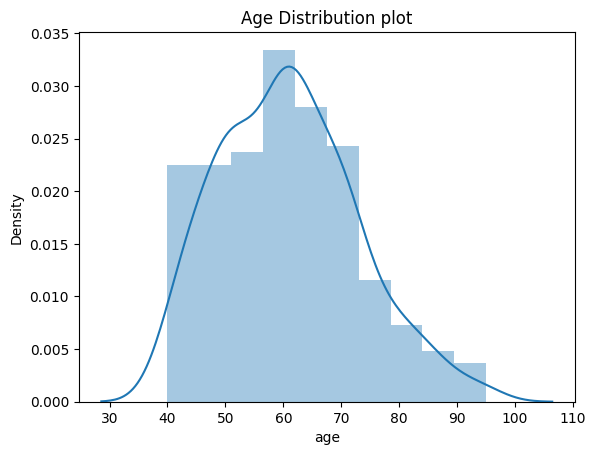

In [ ]:
sns.distplot(heart_data.age).set(title='Age Distribution plot')
plt.show()

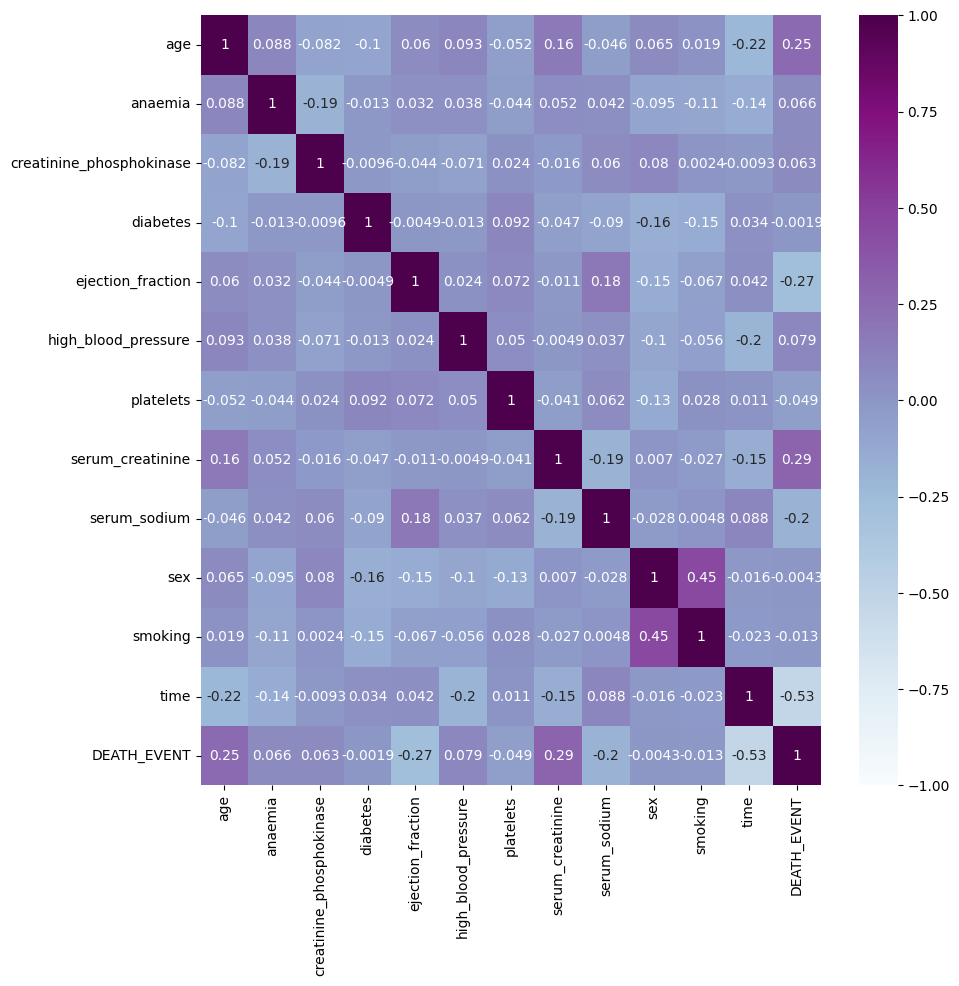

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(heart_data.corr(), vmin=-1, cmap='BuPu', annot=True);

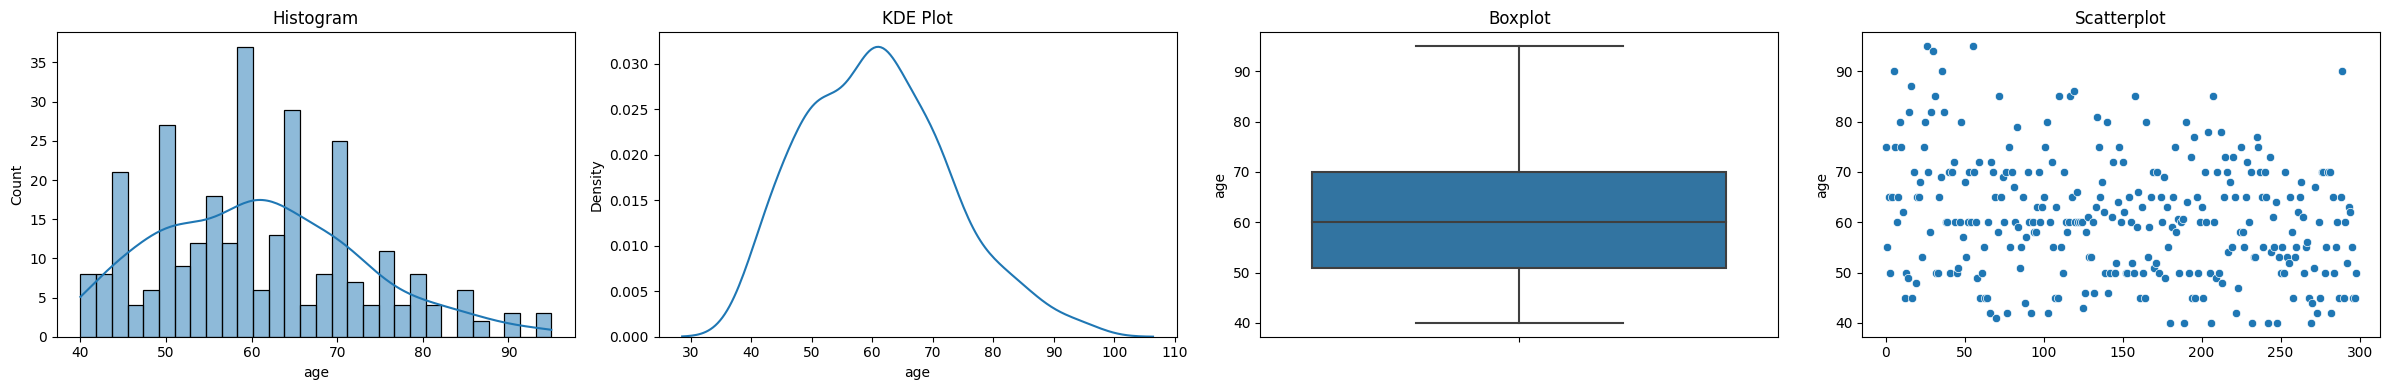

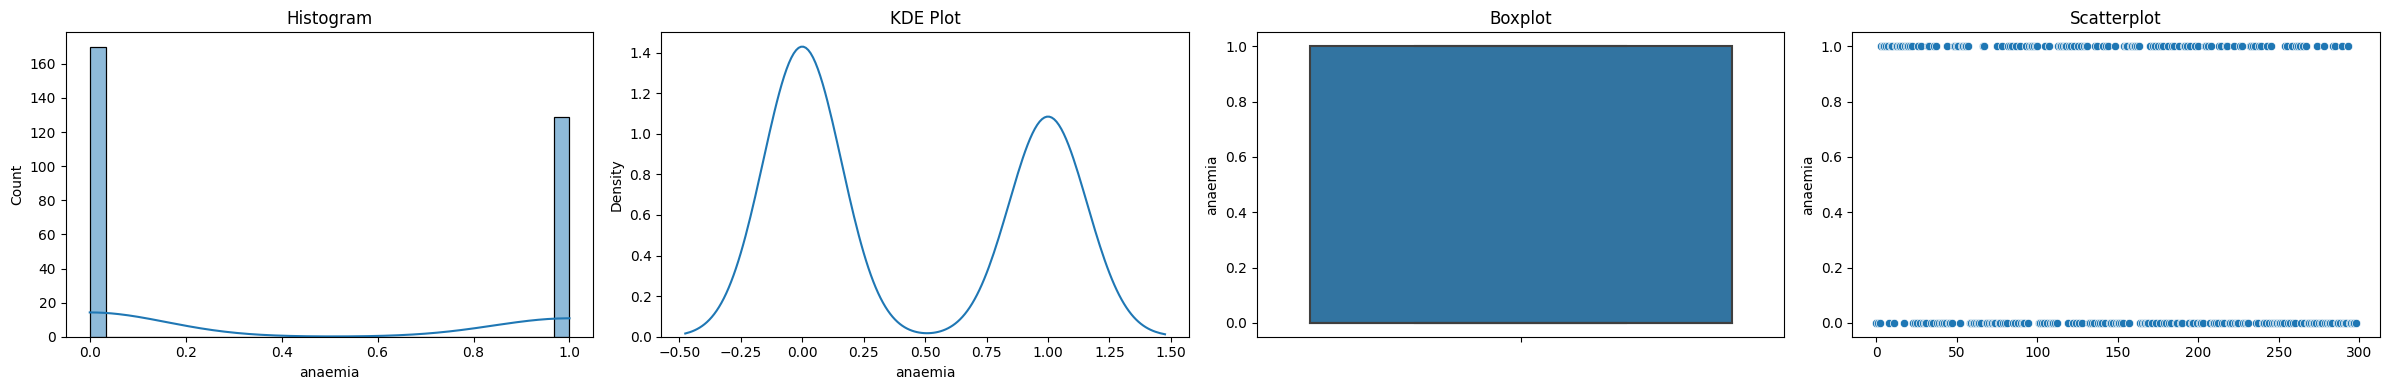

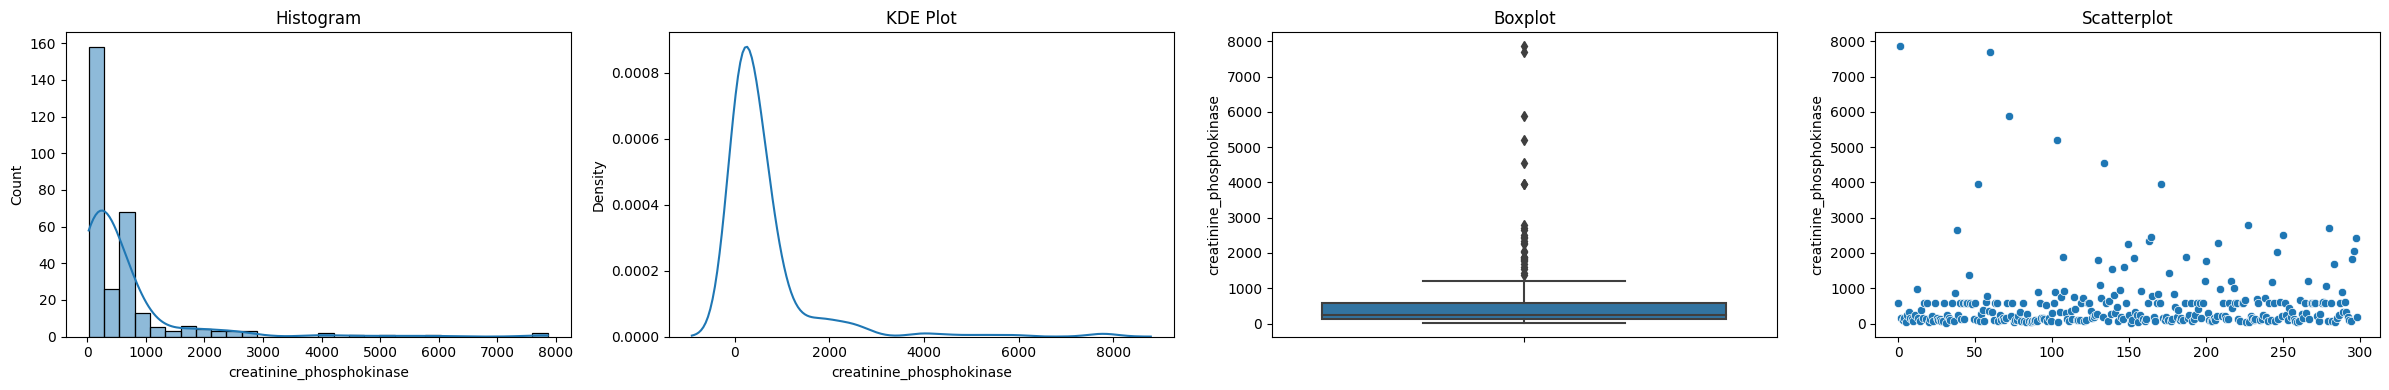

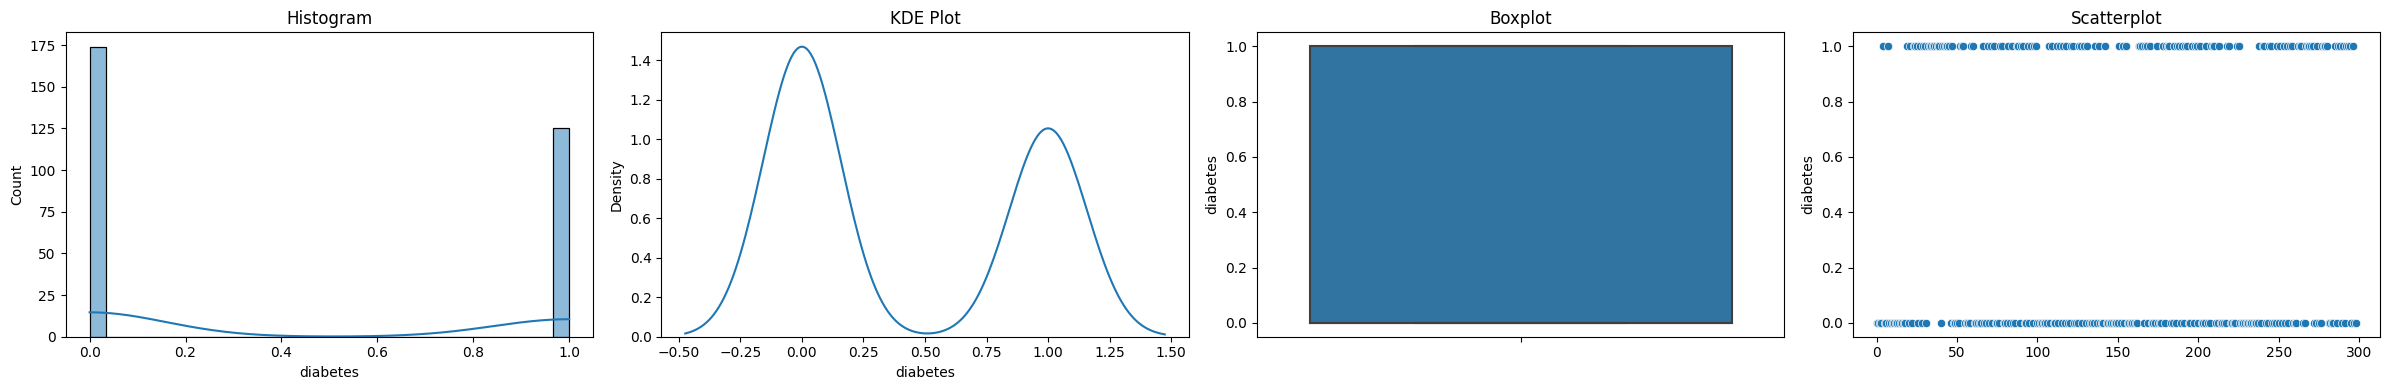

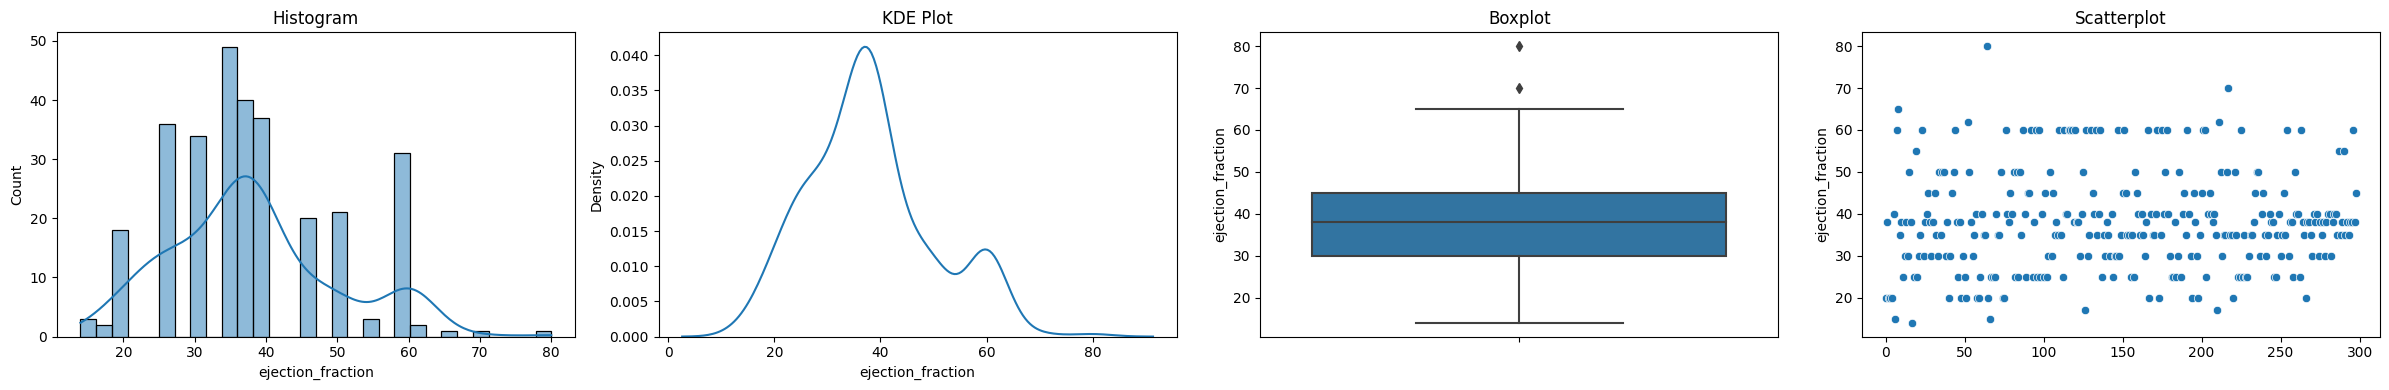

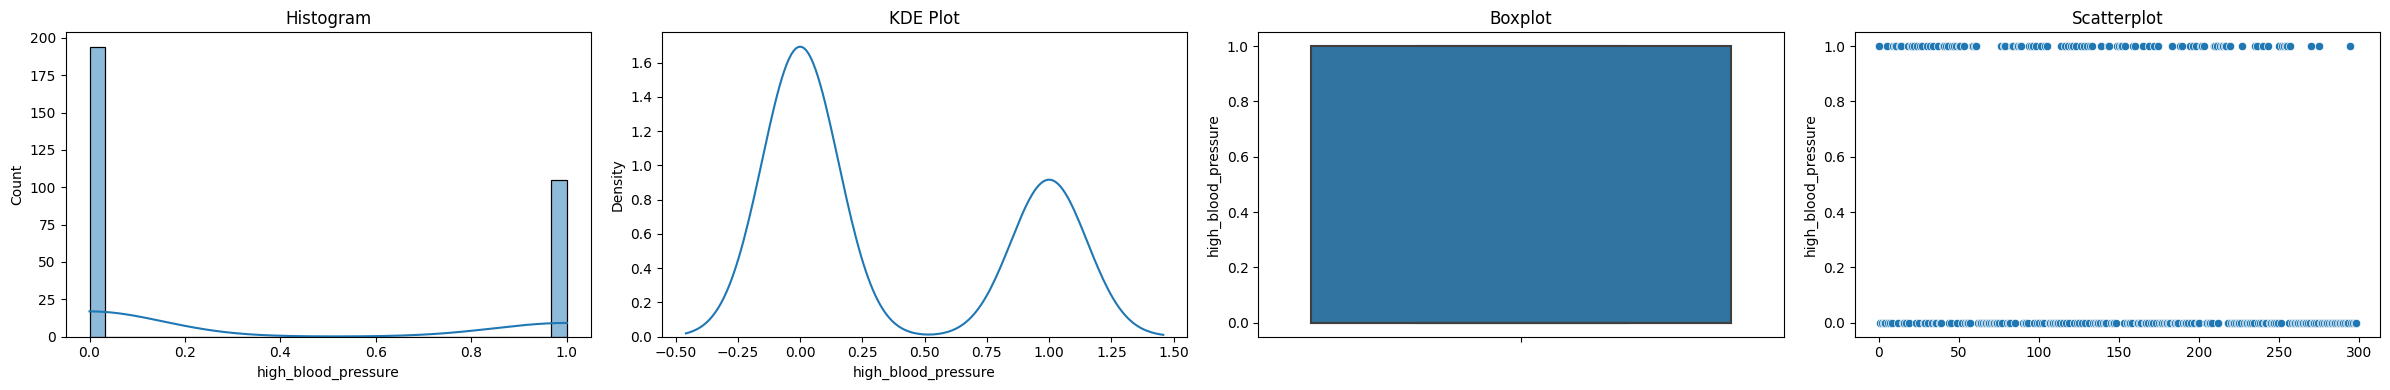

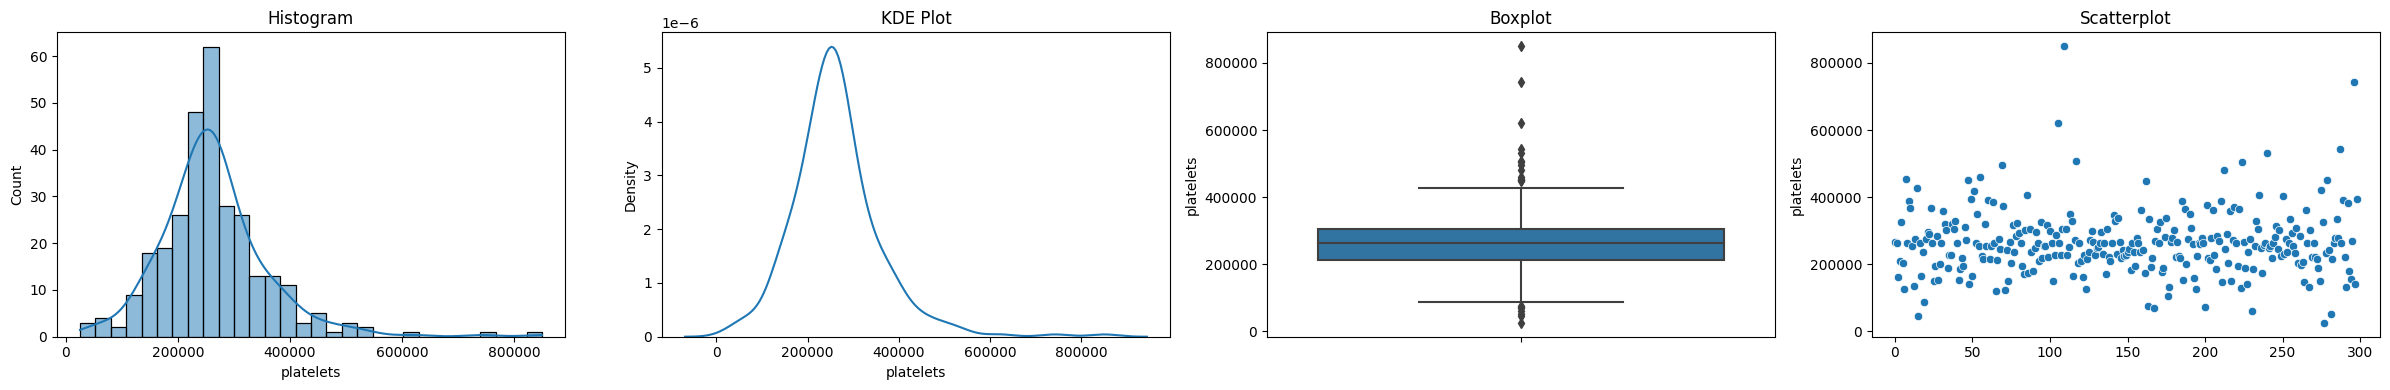

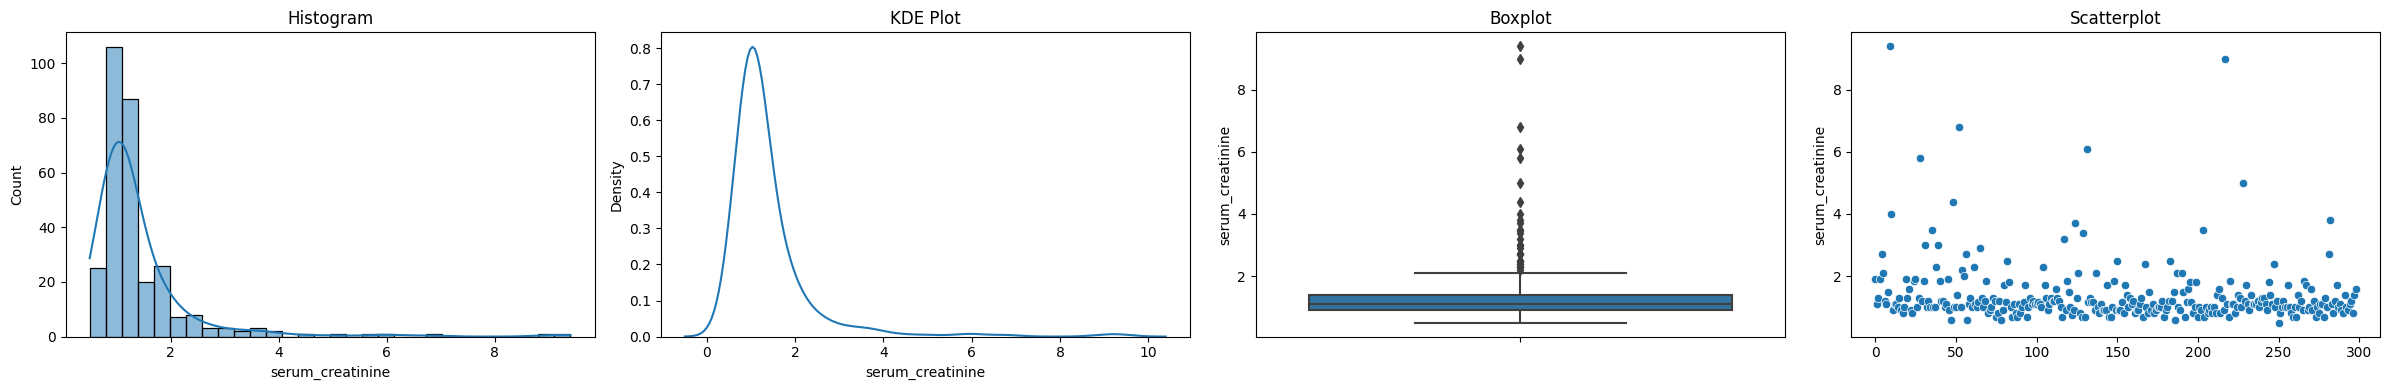

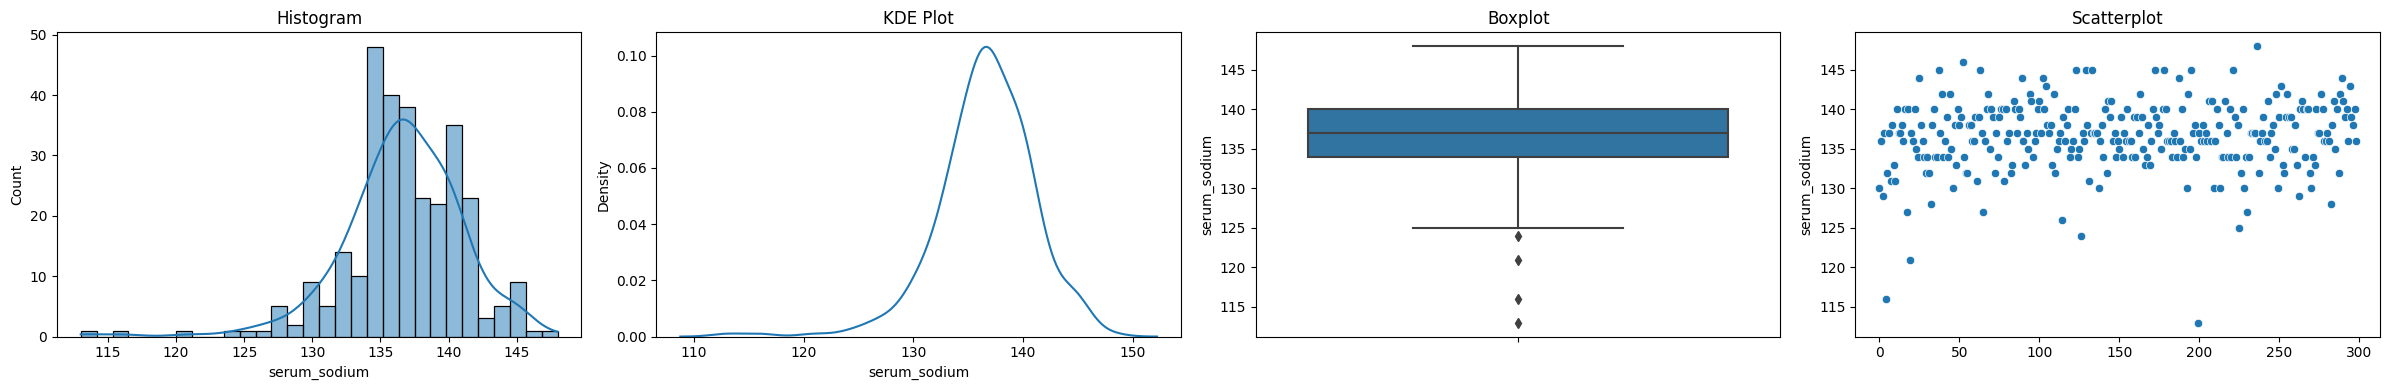

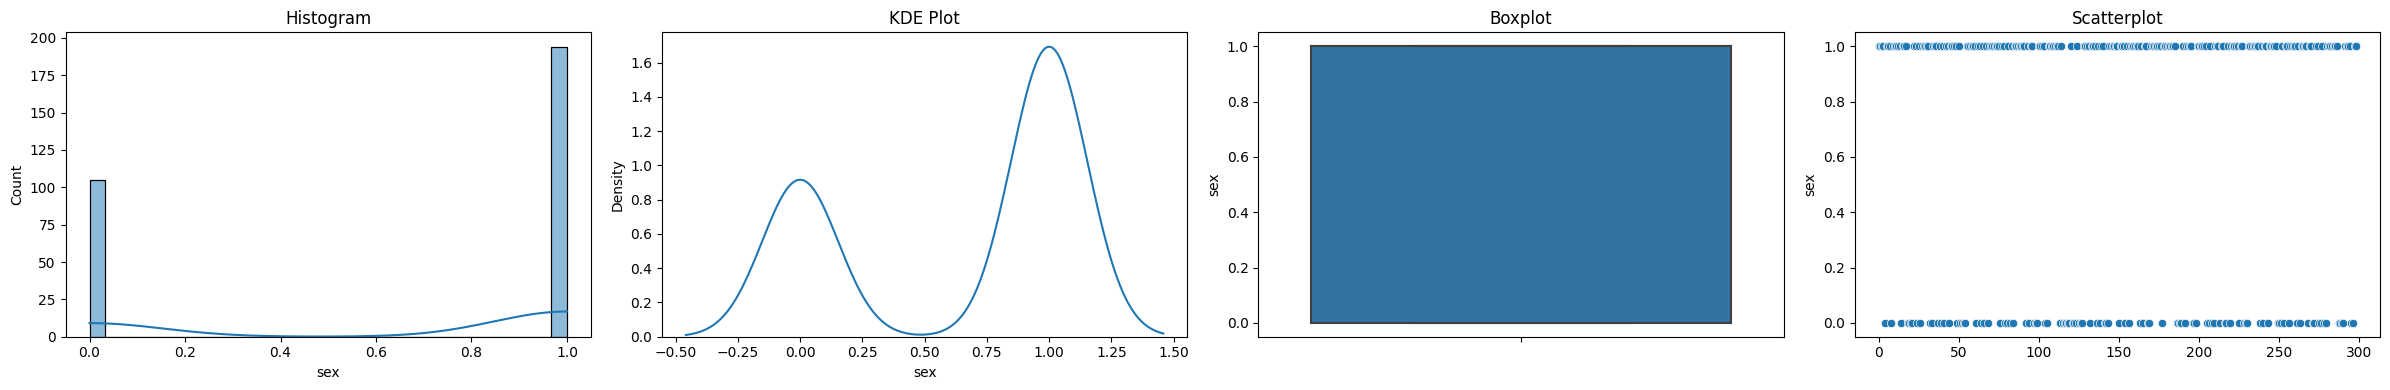

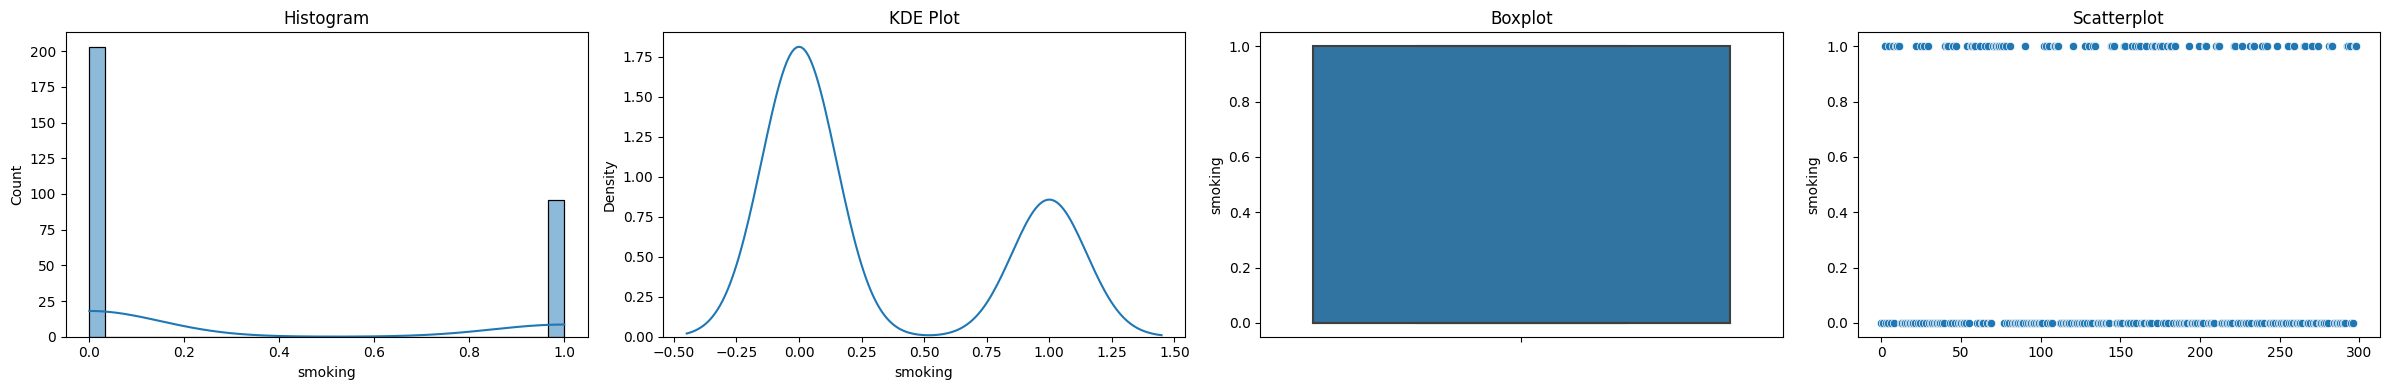

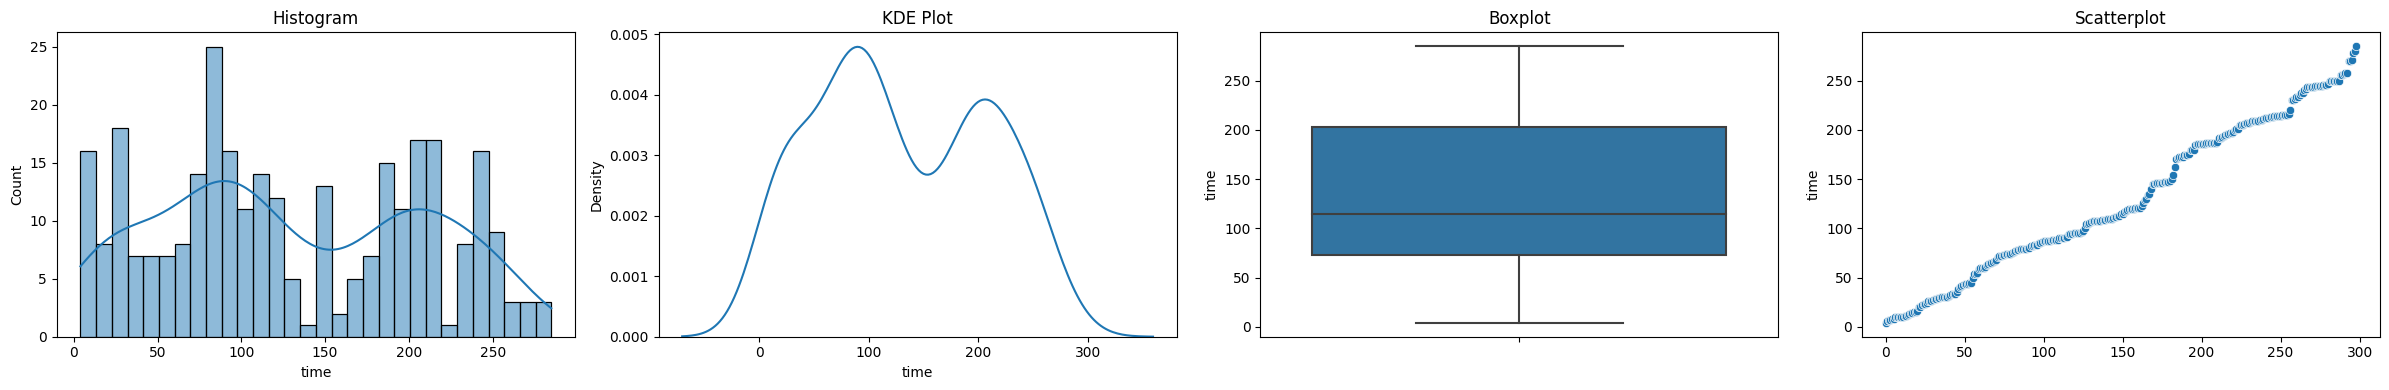

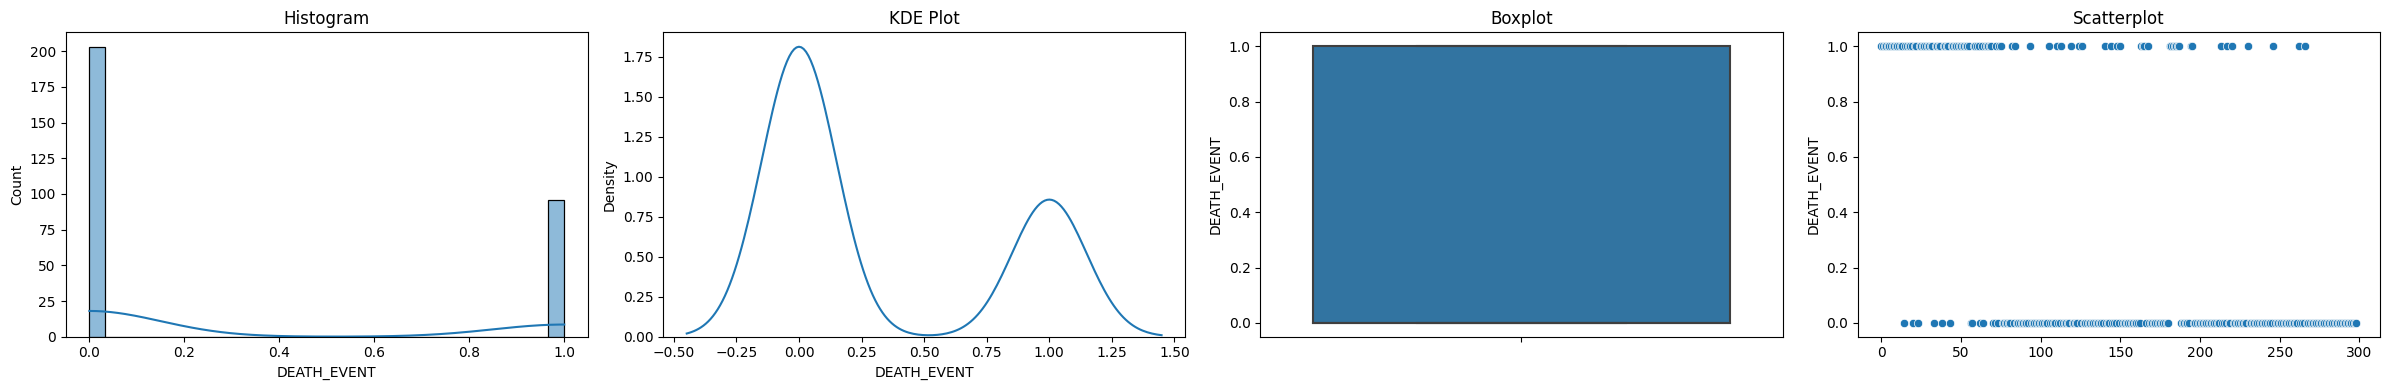

In [ ]:
def plots(heart_data, variable):
  if heart_data[variable].dtype != object:
    # define figure size
    fig, ax = plt.subplots(1, 4, figsize=(24, 4))

    # histogram
    sns.histplot(heart_data[variable], bins=30, kde=True, ax=ax[0])
    ax[0].set_title('Histogram')

    # KDE plot
    sns.kdeplot(heart_data[variable], ax=ax[1])
    ax[1].set_title('KDE Plot')

    # boxplot
    sns.boxplot(y=heart_data[variable], ax=ax[2])
    ax[2].set_title('Boxplot')

    # scatterplot
    sns.scatterplot(x=heart_data.index, y=heart_data[variable], ax=ax[3])
    ax[3].set_title('Scatterplot')

    plt.tight_layout()
    plt.show()

for i in heart_data.columns:
    plots(heart_data ,i)

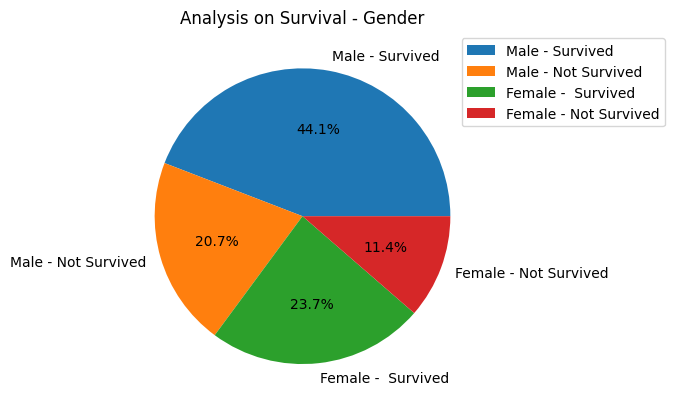

In [ ]:
male = heart_data[heart_data["sex"]==1]
female = heart_data[heart_data["sex"]==0]

male_survi = male[heart_data["DEATH_EVENT"]==0]
male_not = male[heart_data["DEATH_EVENT"]==1]
female_survi = female[heart_data["DEATH_EVENT"]==0]
female_not = female[heart_data["DEATH_EVENT"]==1]

labels = ['Male - Survived','Male - Not Survived', "Female -  Survived", "Female - Not Survived"]
values = [len(male[heart_data["DEATH_EVENT"]==0]),len(male[heart_data["DEATH_EVENT"]==1]),
         len(female[heart_data["DEATH_EVENT"]==0]),len(female[heart_data["DEATH_EVENT"]==1])]

plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.legend(bbox_to_anchor =(1, 0, 0.5, 1))
plt.title("Analysis on Survival - Gender")
plt.show()

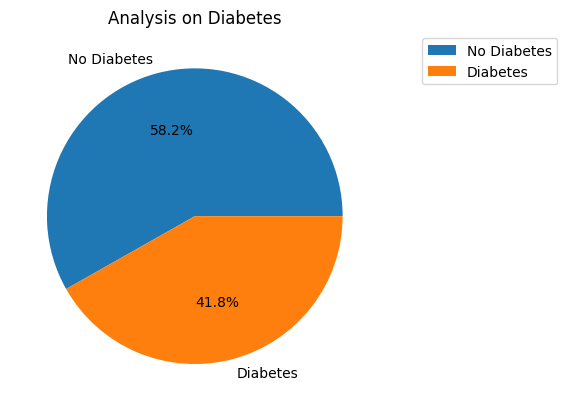

In [ ]:
labels = ['No Diabetes','Diabetes']
diabetes_yes = heart_data[heart_data['diabetes']==1]
diabetes_no = heart_data[heart_data['diabetes']==0]
values = [len(diabetes_no), len(diabetes_yes)]

plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.legend(bbox_to_anchor =(1, 0, 0.5, 1))
plt.title("Analysis on Diabetes")
plt.show()

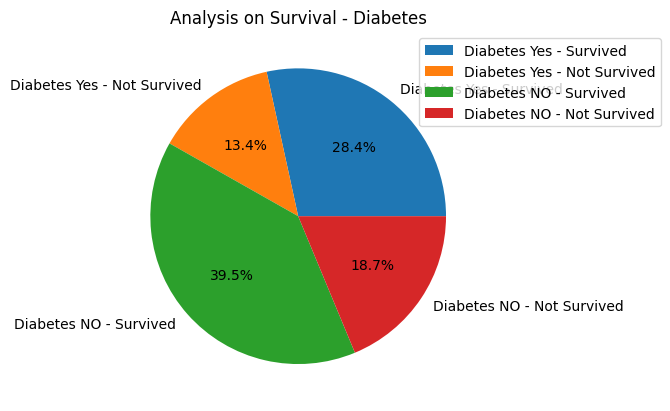

In [ ]:
diabetes_yes_survi = diabetes_yes[heart_data["DEATH_EVENT"]==0]
diabetes_yes_not_survi = diabetes_yes[heart_data["DEATH_EVENT"]==1]
diabetes_no_survi = diabetes_no[heart_data["DEATH_EVENT"]==0]
diabetes__no_not_survi = diabetes_no[heart_data["DEATH_EVENT"]==1]

labels = ['Diabetes Yes - Survived','Diabetes Yes - Not Survived', 'Diabetes NO - Survived', 'Diabetes NO - Not Survived']
values = [len(diabetes_yes[heart_data["DEATH_EVENT"]==0]),len(diabetes_yes[heart_data["DEATH_EVENT"]==1]),
         len(diabetes_no[heart_data["DEATH_EVENT"]==0]),len(diabetes_no[heart_data["DEATH_EVENT"]==1])]

plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.legend(bbox_to_anchor= (1.5, 1))
plt.title("Analysis on Survival - Diabetes")
plt.show()

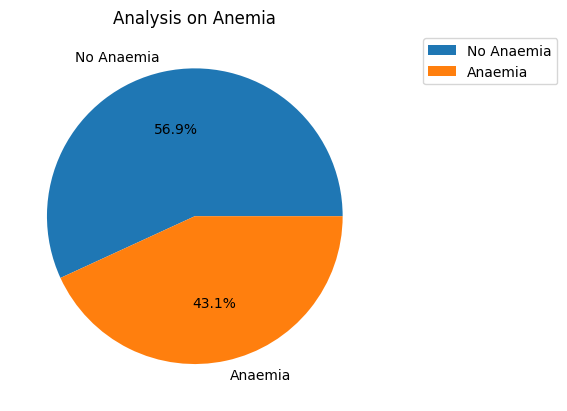

In [ ]:
anaemia_yes = heart_data[heart_data['anaemia']==1]
anaemia_no = heart_data[heart_data['anaemia']==0]

labels = ['No Anaemia', 'Anaemia']
values = [len(anaemia_no), len(anaemia_yes)]

plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.legend(bbox_to_anchor =(1, 0, 0.5, 1))
plt.title("Analysis on Anemia")
plt.show()

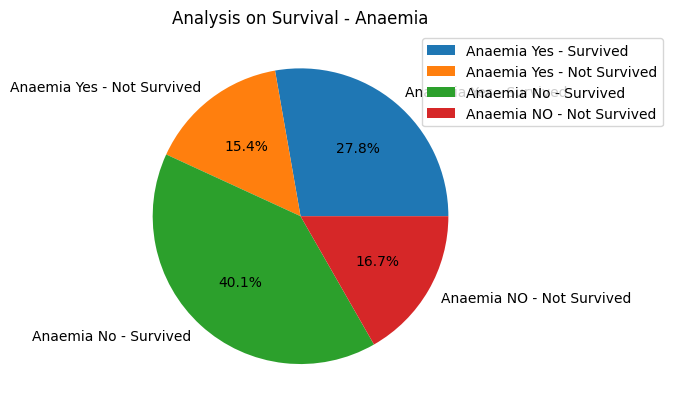

In [ ]:
anaemia_yes_survi = anaemia_yes[heart_data["DEATH_EVENT"]==0]
anaemia_yes_not_survi = anaemia_yes[heart_data["DEATH_EVENT"]==1]
anaemia_no_survi = anaemia_no[heart_data["DEATH_EVENT"]==0]
anaemia_no_not_survi = anaemia_no[heart_data["DEATH_EVENT"]==1]

labels = ['Anaemia Yes - Survived','Anaemia Yes - Not Survived', 'Anaemia No - Survived', 'Anaemia NO - Not Survived']
values = [len(anaemia_yes[heart_data["DEATH_EVENT"]==0]),len(anaemia_yes[heart_data["DEATH_EVENT"]==1]),
         len(anaemia_no[heart_data["DEATH_EVENT"]==0]),len(anaemia_no[heart_data["DEATH_EVENT"]==1])]

plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.legend(bbox_to_anchor= (1.5, 1))
plt.title("Analysis on Survival - Anaemia")
plt.show()

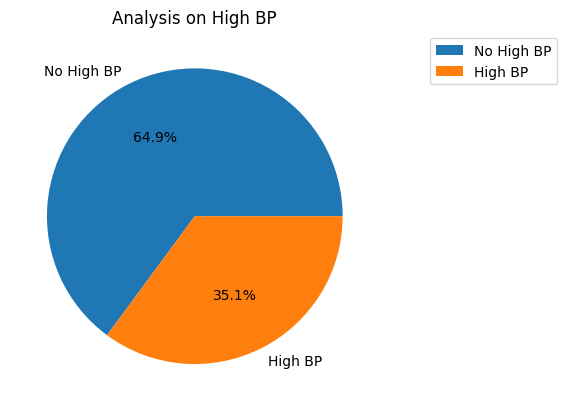

In [ ]:
hbp_yes = heart_data[heart_data['high_blood_pressure']==1]
hbp_no = heart_data[heart_data['high_blood_pressure']==0]

labels = ["No High BP","High BP"]
values = [len(hbp_no), len(hbp_yes)]

plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.legend(bbox_to_anchor =(1, 0, 0.5, 1))
plt.title("Analysis on High BP")
plt.show()

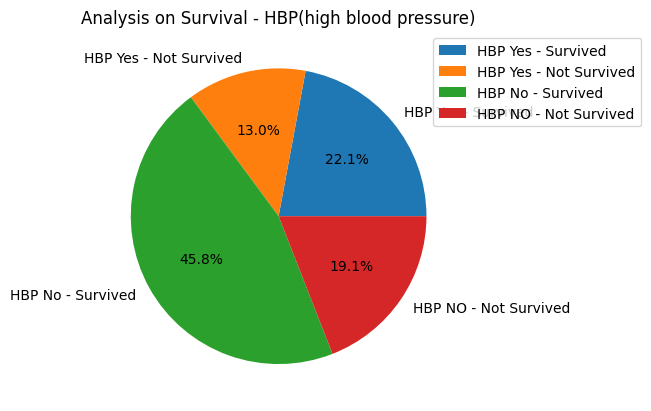

In [ ]:
hbp_yes_survi = hbp_yes[heart_data["DEATH_EVENT"]==0]
hbp_yes_not_survi = hbp_yes[heart_data["DEATH_EVENT"]==1]
hbp_no_survi = hbp_no[heart_data["DEATH_EVENT"]==0]
hbp_no_not_survi = hbp_no[heart_data["DEATH_EVENT"]==1]

labels = ['HBP Yes - Survived','HBP Yes - Not Survived', 'HBP No - Survived', 'HBP NO - Not Survived']
values = [len(hbp_yes[heart_data["DEATH_EVENT"]==0]),len(hbp_yes[heart_data["DEATH_EVENT"]==1]),
         len(hbp_no[heart_data["DEATH_EVENT"]==0]),len(hbp_no[heart_data["DEATH_EVENT"]==1])]

plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.legend(bbox_to_anchor= (1.5, 1))
plt.title("Analysis on Survival - HBP(high blood pressure)")
plt.show()

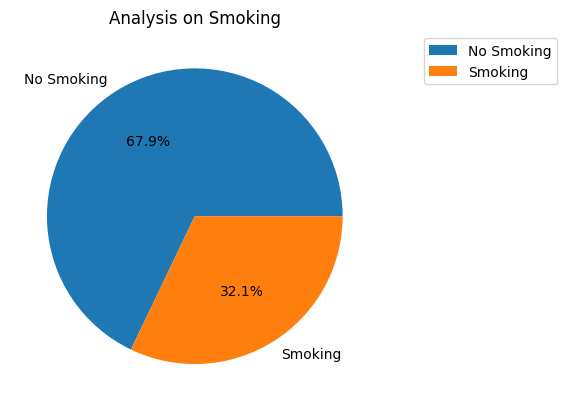

In [ ]:
smoking_yes = heart_data[heart_data['smoking']==1]
smoking_no = heart_data[heart_data['smoking']==0]

labels = ['No Smoking','Smoking']
values = [len(smoking_no), len(smoking_yes)]

plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.legend(bbox_to_anchor =(1, 0, 0.5, 1))
plt.title("Analysis on Smoking")
plt.show()

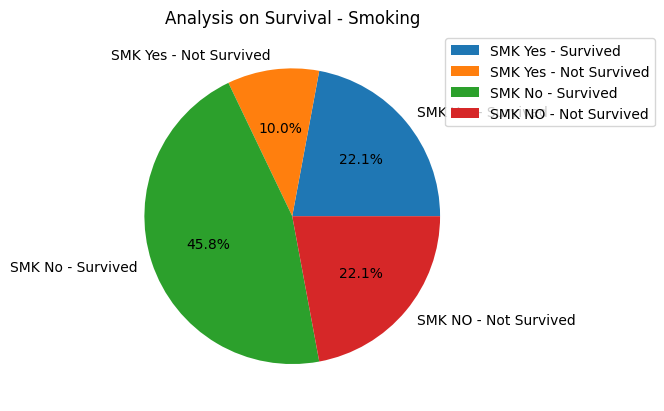

In [ ]:
smk_yes_survi = smoking_yes[heart_data["DEATH_EVENT"]==0]
smk_yes_not_survi = smoking_yes[heart_data["DEATH_EVENT"]==1]
smk_no_survi = smoking_no[heart_data["DEATH_EVENT"]==0]
smk_no_not_survi = smoking_no[heart_data["DEATH_EVENT"]==1]

labels = ['SMK Yes - Survived','SMK Yes - Not Survived', 'SMK No - Survived', 'SMK NO - Not Survived']
values = [len(smoking_yes[heart_data["DEATH_EVENT"]==0]),len(smoking_yes[heart_data["DEATH_EVENT"]==1]),
         len(smoking_no[heart_data["DEATH_EVENT"]==0]),len(smoking_no[heart_data["DEATH_EVENT"]==1])]

plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.legend(bbox_to_anchor= (1.5, 1))
plt.title("Analysis on Survival - Smoking")
plt.show()

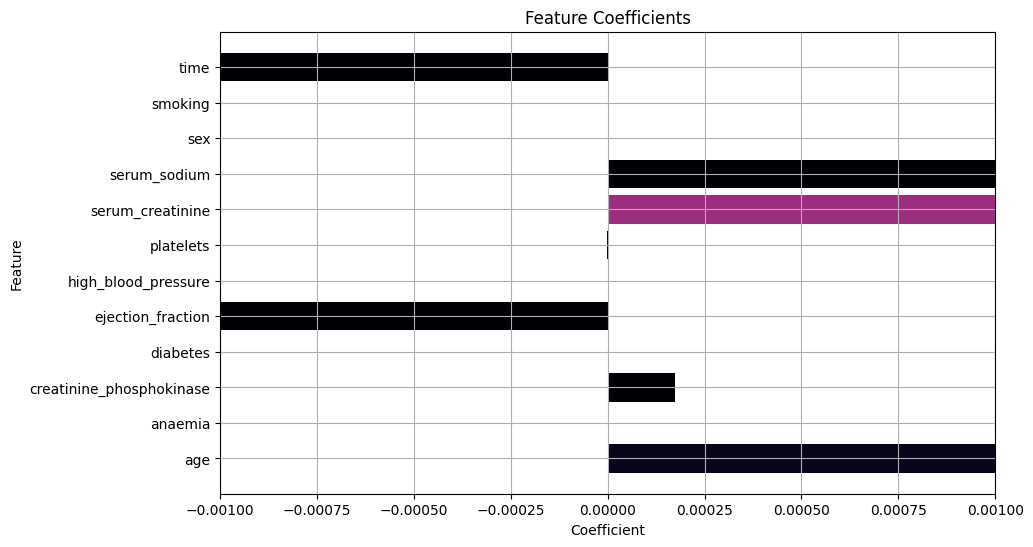

Number transactions X_train dataset:  (239, 7)
Number transactions y_train dataset:  (239,)
Number transactions X_test dataset:  (60, 7)
Number transactions y_test dataset:  (60,)
Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'time'],
      dtype='object')
7


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Select features and target variable
Features = heart_data.iloc[:, :-1]
y = heart_data["DEATH_EVENT"]

# Lasso feature selection
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
lasso.fit(Features, y)
correlation_scores = lasso.coef_[0]
feature_names = Features.columns
sorted_features_coef = sorted(zip(feature_names, correlation_scores), key=lambda x: x[1])
selected_features_lasso = feature_names[lasso.coef_[0] != 0]


# Plot feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), correlation_scores, align='center', color=plt.cm.magma(correlation_scores))
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.grid(True)
xmin = -0.001
xmax = 0.001
plt.xlim(xmin, xmax)
plt.show()

# Split data into train and test sets using selected features from Lasso
x_train, x_test, y_train, y_test = train_test_split(Features[selected_features_lasso], y, test_size=0.2, random_state=2)
print("Number transactions X_train dataset: ", x_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", x_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)
print(selected_features_lasso)
print(len(selected_features_lasso))


In [ ]:
sm = SMOTE(random_state=5)
x_train, y_train = sm.fit_resample(x_train, y_train)

In [ ]:
accuracy_list = []
precision_list=[]
recall_list=[]
f1_list=[]
Sensitivity_list=[]
Specificity_list=[]
rocscore_list=[]
Gmean_list=[]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)
ridge = Ridge(alpha=1.0)  # You can adjust the regularization strength by changing the alpha parameter
ridge.fit(X_train_scaled, y_train)
rid_pred = ridge.predict(X_test_scaled)
# Evaluate the model
mse = mean_squared_error(y_test, rid_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, rid_pred)
print("R2 Score:", r2)

Mean Squared Error: 0.1214584783198802
R2 Score: 0.40184607120168425


<Figure size 640x480 with 0 Axes>

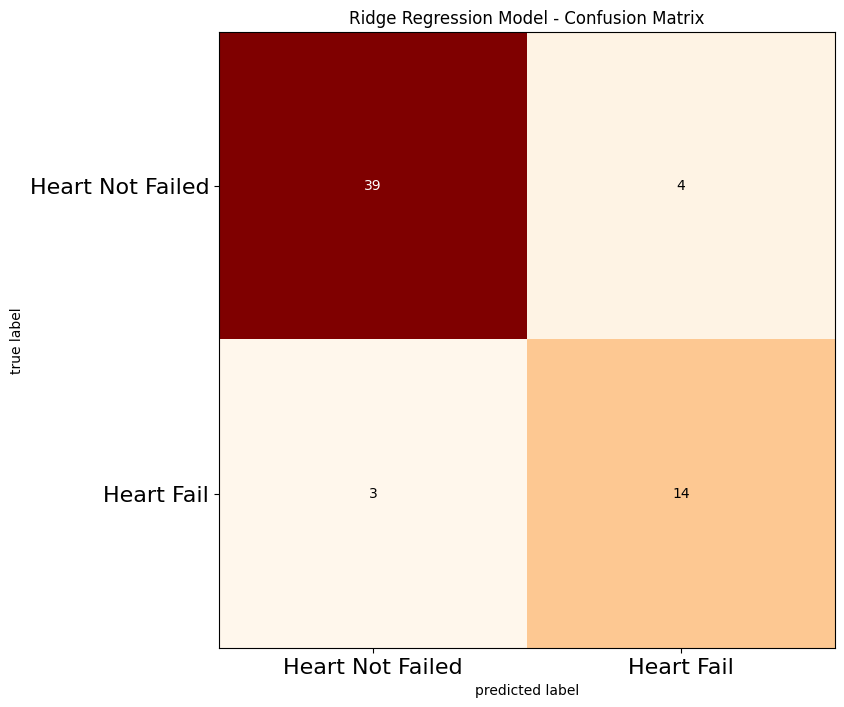

In [ ]:
y_pred_prob = ridge.predict(X_test_scaled)
threshold = 0.5
rid_pred = np.where(y_pred_prob >= threshold, 1, 0)
cm = confusion_matrix(y_test, rid_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.OrRd)
plt.title("Ridge Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
print("The Performance Score:")
rid_reg_acc = accuracy_score(y_test, rid_pred)
accuracy_list.append(100*rid_reg_acc)
print("Accuracy:",rid_reg_acc)

prec=precision_score(y_test,rid_pred)
print("Precision:",prec)
precision_list.append(100*prec)

rec=recall_score(y_test,rid_pred)
print("Recall:",rec)
recall_list.append(100*rec)

f1=f1_score(y_test,rid_pred)
print("F1 Score:",f1)
f1_list.append(100*f1)

total1=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity: ', sensitivity )
Sensitivity_list.append(100*sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity: ', specificity)
Specificity_list.append(100*specificity)

roc=roc_auc_score(y_test,rid_pred)
print("ROC Score:",roc)
rocscore_list.append(100*roc)

gm=geometric_mean_score(y_test,rid_pred)
print("Geometric Mean:",gm)
Gmean_list.append(100*gm)

The Performance Score:
Accuracy: 0.8833333333333333
Precision: 0.7777777777777778
Recall: 0.8235294117647058
F1 Score: 0.7999999999999999
Sensitivity:  0.9069767441860465
Specificity:  0.8235294117647058
ROC Score: 0.8652530779753762
Geometric Mean: 0.8642465068623667


In [ ]:
import pandas as pd
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)
lasso = Lasso(alpha=1.0)
lasso.fit(x_train, y_train)
lasso_pred = lasso.predict(X_test_scaled)
mse = mean_squared_error(y_test, lasso_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, lasso_pred)
print("R2 Score:", r2)

Mean Squared Error: 0.8506029323885202
R2 Score: -3.1890158093005114


<Figure size 640x480 with 0 Axes>

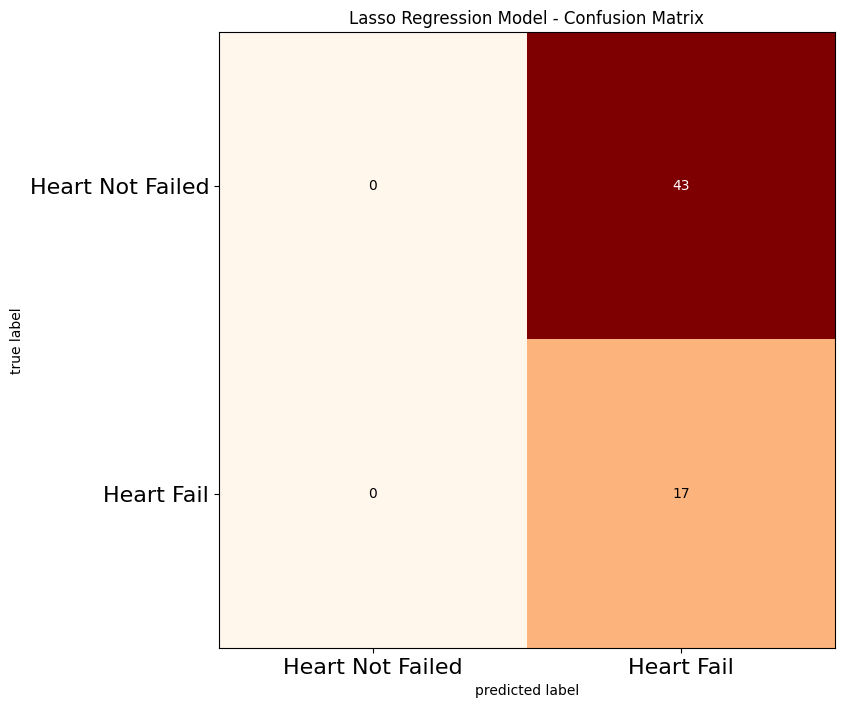

In [ ]:
lasso_pred_prob = lasso.predict(X_test_scaled)
threshold = 0.5
lasso_pred = np.where(lasso_pred_prob >= threshold, 1, 0)
cm = confusion_matrix(y_test, lasso_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.OrRd)
plt.title("Lasso Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
print("The Performance Score:")
lasso_reg_acc = accuracy_score(y_test, lasso_pred)
accuracy_list.append(100*lasso_reg_acc)
print("Accuracy:",lasso_reg_acc)

prec=precision_score(y_test,lasso_pred)
print("Precision:",prec)
precision_list.append(100*prec)

rec=recall_score(y_test,lasso_pred)
print("Recall:",rec)
recall_list.append(100*rec)

f1=f1_score(y_test,lasso_pred)
print("F1 Score:",f1)
f1_list.append(100*f1)

total1=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity: ', sensitivity )
Sensitivity_list.append(100*sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity: ', specificity)
Specificity_list.append(100*specificity)

roc=roc_auc_score(y_test,lasso_pred)
print("ROC Score:",roc)
rocscore_list.append(100*roc)

gm=geometric_mean_score(y_test,lasso_pred)
print("Geometric Mean:",gm)
Gmean_list.append(100*gm)

The Performance Score:
Accuracy: 0.2833333333333333
Precision: 0.2833333333333333
Recall: 1.0
F1 Score: 0.4415584415584416
Sensitivity:  0.0
Specificity:  1.0
ROC Score: 0.5
Geometric Mean: 0.0


In [ ]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg_pred = log_reg.predict(x_test)


<Figure size 640x480 with 0 Axes>

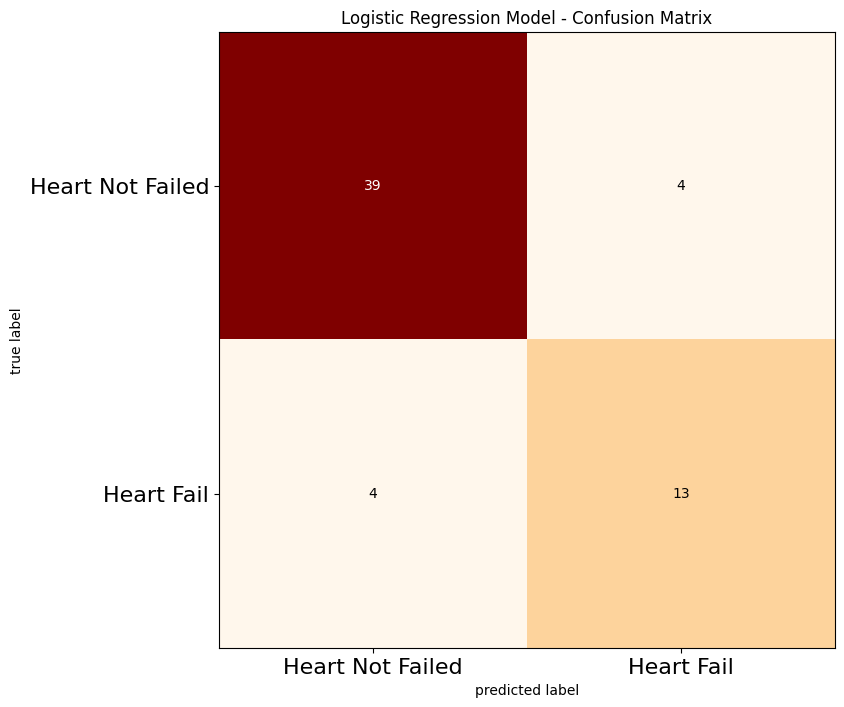

In [ ]:
cm = confusion_matrix(y_test, log_reg_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.OrRd)
plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
print("The Performance Score:")
log_reg_acc = accuracy_score(y_test, log_reg_pred)
accuracy_list.append(100*log_reg_acc)
print("Accuracy:",log_reg_acc)

prec=precision_score(y_test,log_reg_pred)
print("Precision:",prec)
precision_list.append(100*prec)

rec=recall_score(y_test,log_reg_pred)
print("Recall:",rec)
recall_list.append(100*rec)

f1=f1_score(y_test,log_reg_pred)
print("F1 Score:",f1)
f1_list.append(100*f1)

total1=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity: ', sensitivity )
Sensitivity_list.append(100*sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity: ', specificity)
Specificity_list.append(100*specificity)

roc=roc_auc_score(y_test,log_reg_pred)
print("ROC Score:",roc)
rocscore_list.append(100*roc)

gm=geometric_mean_score(y_test,log_reg_pred)
print("Geometric Mean:",gm)
Gmean_list.append(100*gm)

The Performance Score:
Accuracy: 0.8666666666666667
Precision: 0.7647058823529411
Recall: 0.7647058823529411
F1 Score: 0.7647058823529412
Sensitivity:  0.9069767441860465
Specificity:  0.7647058823529411
ROC Score: 0.8358413132694938
Geometric Mean: 0.8328087724300149


In [ ]:
kn_clf = KNeighborsClassifier(n_neighbors=6)
kn_clf.fit(x_train, y_train)
kn_pred = kn_clf.predict(x_test)


<Figure size 640x480 with 0 Axes>

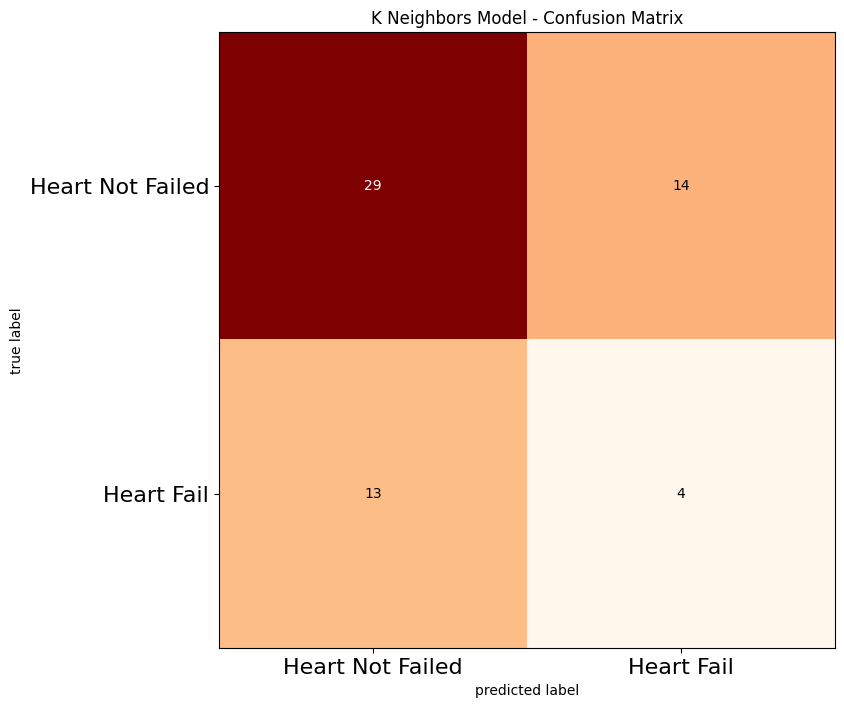

In [ ]:
cm = confusion_matrix(y_test, kn_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.OrRd)
plt.title("K Neighbors Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
print("The Performance Score:")
kn_acc = accuracy_score(y_test, kn_pred)
accuracy_list.append(100*kn_acc)
print("Accuracy:",kn_acc)

prec=precision_score(y_test,kn_pred)
print("Precision:",prec)
precision_list.append(100*prec)

rec=recall_score(y_test,kn_pred)
print("Recall",rec)
recall_list.append(100*rec)

f1=f1_score(y_test,kn_pred)
print("F1 Score:",f1)
f1_list.append(100*f1)

total1=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity: ', sensitivity )
Sensitivity_list.append(100*sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity: ', specificity)
Specificity_list.append(100*specificity)

roc=roc_auc_score(y_test,kn_pred)
print("ROC Score:",roc)
rocscore_list.append(100*roc)

gm=geometric_mean_score(y_test,kn_pred)
print("Geometric Mean:",gm)
Gmean_list.append(100*gm)

The Performance Score:
Accuracy: 0.55
Precision: 0.2222222222222222
Recall 0.23529411764705882
F1 Score: 0.22857142857142856
Sensitivity:  0.6744186046511628
Specificity:  0.23529411764705882
ROC Score: 0.4548563611491108
Geometric Mean: 0.39835503072781187


In [ ]:
r_clf = RandomForestClassifier(max_features=0.5, max_depth=15, random_state=1)
r_clf.fit(x_train, y_train)
r_pred = r_clf.predict(x_test)

<Figure size 640x480 with 0 Axes>

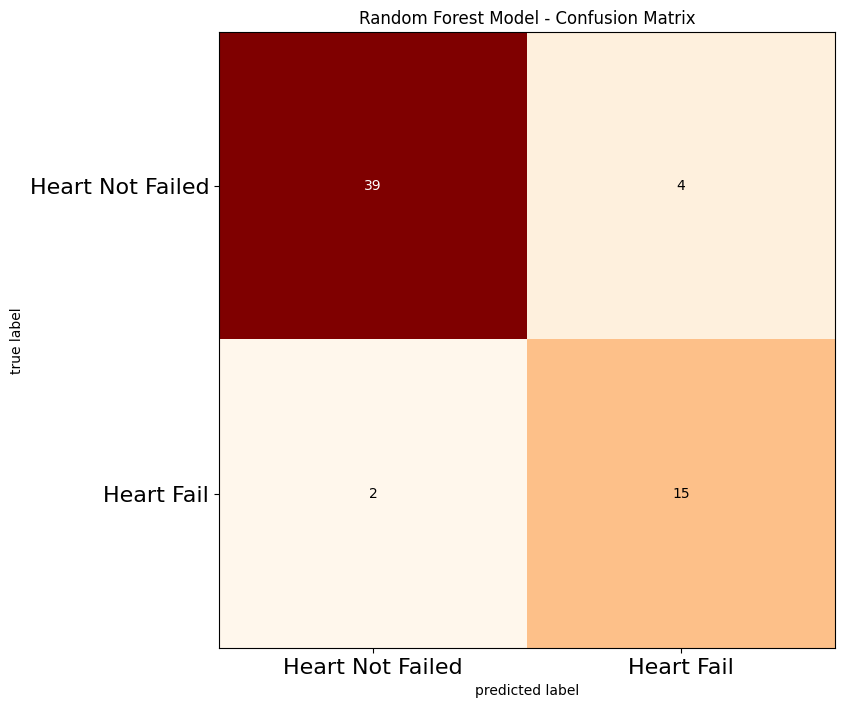

In [ ]:
cm = confusion_matrix(y_test, r_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.OrRd)
plt.title("Random Forest Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
print("The Performance Score:")
r_acc = accuracy_score(y_test, r_pred)
accuracy_list.append(100*r_acc)
print("Accuracy:",r_acc)

prec=precision_score(y_test,r_pred)
print("Precision:",prec)
precision_list.append(100*prec)

rec=recall_score(y_test,r_pred)
print("Recall:",rec)
recall_list.append(100*rec)

f1=f1_score(y_test,r_pred)
print("F1 Score:",f1)
f1_list.append(100*f1)

total1=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity:', sensitivity )
Sensitivity_list.append(100*sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity:', specificity)
Specificity_list.append(100*specificity)

roc=roc_auc_score(y_test,r_pred)
print("ROC Score:",roc)
rocscore_list.append(100*roc)

gm=geometric_mean_score(y_test,r_pred)
print("Geometric Mean:",gm)
Gmean_list.append(100*gm)

The Performance Score:
Accuracy: 0.9
Precision: 0.7894736842105263
Recall: 0.8823529411764706
F1 Score: 0.8333333333333333
Sensitivity: 0.9069767441860465
Specificity: 0.8823529411764706
ROC Score: 0.8946648426812586
Geometric Mean: 0.8945801237514823


In [ ]:
xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=1)
xgb_clf.fit(x_train, y_train)
xgb_pred = xgb_clf.predict(x_test)

<Figure size 640x480 with 0 Axes>

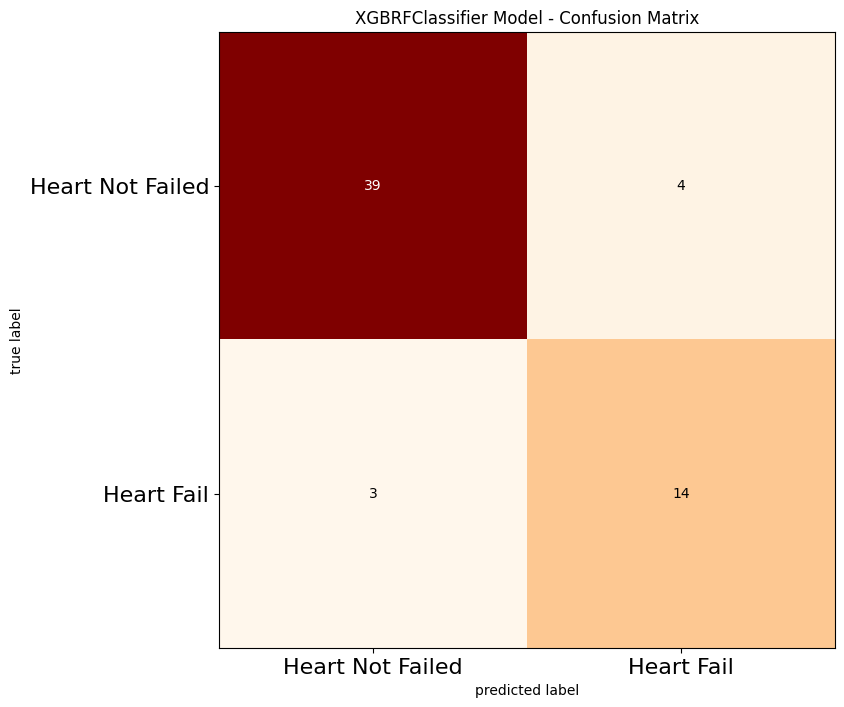

In [ ]:
cm = confusion_matrix(y_test, xgb_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.OrRd)
plt.title("XGBRFClassifier Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
print("The Performance Score:")
xgb_acc = accuracy_score(y_test, xgb_pred)
accuracy_list.append(100*xgb_acc)
print("Accuracy:",xgb_acc)

prec=precision_score(y_test,xgb_pred)
print("Precision:",prec)
precision_list.append(100*prec)

rec=recall_score(y_test,xgb_pred)
print("Recall:",rec)
recall_list.append(100*rec)

f1=f1_score(y_test,xgb_pred)
print("F1 score:",f1)
f1_list.append(100*f1)

total1=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity:', sensitivity )
Sensitivity_list.append(100*sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity:', specificity)
Specificity_list.append(100*specificity)

roc=roc_auc_score(y_test,xgb_pred)
print("ROC Score:",roc)
rocscore_list.append(100*roc)

gm=geometric_mean_score(y_test,xgb_pred)
print("Geometric Mean:",gm)
Gmean_list.append(100*gm)

The Performance Score:
Accuracy: 0.8833333333333333
Precision: 0.7777777777777778
Recall: 0.8235294117647058
F1 score: 0.7999999999999999
Sensitivity: 0.9069767441860465
Specificity: 0.8235294117647058
ROC Score: 0.8652530779753762
Geometric Mean: 0.8642465068623667


In [ ]:
dt_clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0, criterion='entropy')
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_test)

<Figure size 640x480 with 0 Axes>

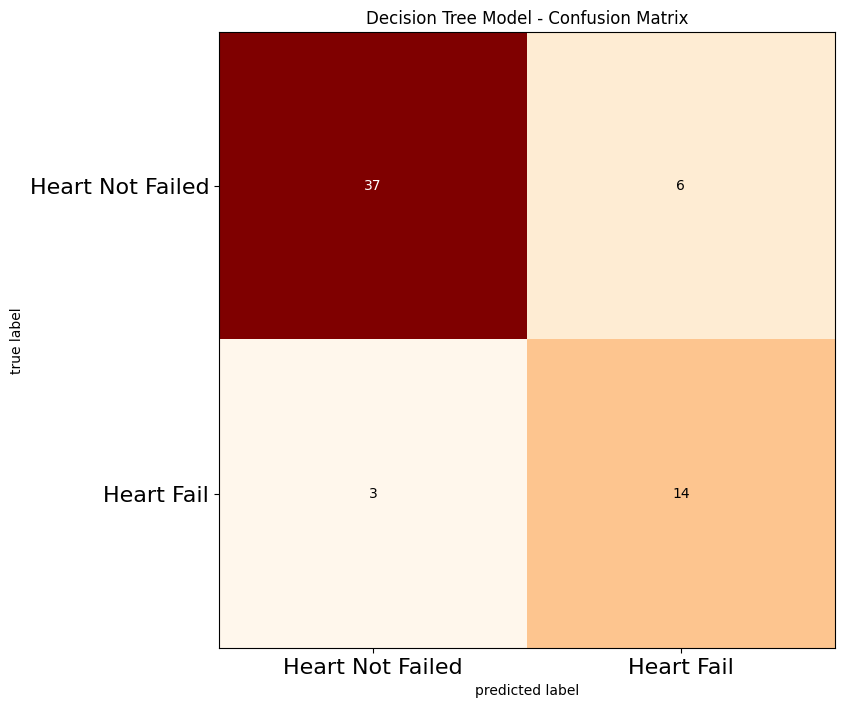

In [ ]:
cm = confusion_matrix(y_test, dt_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.OrRd)
plt.title("Decision Tree Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
print("The Performance Score:")
dt_acc = accuracy_score(y_test, dt_pred)
accuracy_list.append(100*dt_acc)
print("Accuracy:",dt_acc)

prec=precision_score(y_test,dt_pred)
print("Precision:",prec)
precision_list.append(100*prec)

rec=recall_score(y_test,dt_pred)
print("Recall:",rec)
recall_list.append(100*rec)

f1=f1_score(y_test,dt_pred)
print("F1 Score:",f1)
f1_list.append(100*f1)

total1=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity:', sensitivity )
Sensitivity_list.append(100*sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity:', specificity)
Specificity_list.append(100*specificity)

roc=roc_auc_score(y_test,dt_pred)
print("ROC Score:",roc)
rocscore_list.append(100*roc)

gm=geometric_mean_score(y_test,dt_pred)
print("Geomtric Mean:",gm)
Gmean_list.append(100*gm)

The Performance Score:
Accuracy: 0.85
Precision: 0.7
Recall: 0.8235294117647058
F1 Score: 0.7567567567567567
Sensitivity: 0.8604651162790697
Specificity: 0.8235294117647058
ROC Score: 0.8419972640218878
Geomtric Mean: 0.8417947083780888


In [ ]:
rlf = svm.SVC(kernel='rbf')
rlf.fit(x_train, y_train)
svmr_pred = rlf.predict(x_test)

<Figure size 640x480 with 0 Axes>

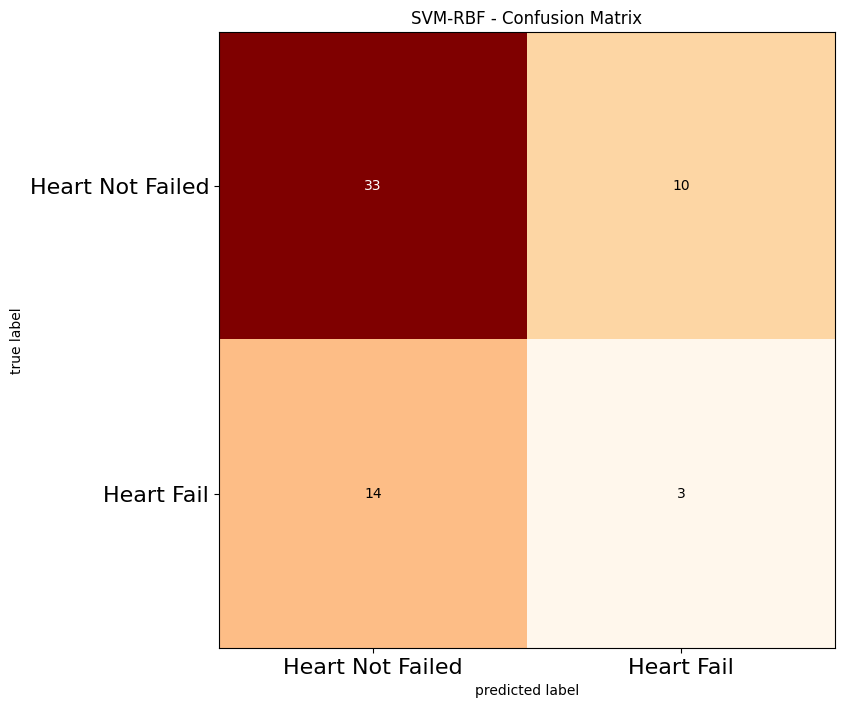

In [ ]:
cm = confusion_matrix(y_test, svmr_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.OrRd)
plt.title("SVM-RBF - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
print("The Performance Score:")
svmr_acc = accuracy_score(y_test, svmr_pred)
accuracy_list.append(100*svmr_acc)
print("Accuracy:",svmr_acc)

prec=precision_score(y_test,svmr_pred)
print("Precision:",prec)
precision_list.append(100*prec)

rec=recall_score(y_test,svmr_pred)
print("Recall:",rec)
recall_list.append(100*rec)

f1=f1_score(y_test,svmr_pred)
print("F1 Score:",f1)
f1_list.append(100*f1)

total1=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity:', sensitivity )
Sensitivity_list.append(100*sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity:', specificity)
Specificity_list.append(100*specificity)

roc=roc_auc_score(y_test,svmr_pred)
print("ROC Score:",roc)
rocscore_list.append(100*roc)

gm=geometric_mean_score(y_test,svmr_pred)
print("Geometric Mean:",gm)
Gmean_list.append(100*gm)

The Performance Score:
Accuracy: 0.6
Precision: 0.23076923076923078
Recall: 0.17647058823529413
F1 Score: 0.20000000000000004
Sensitivity: 0.7674418604651163
Specificity: 0.17647058823529413
ROC Score: 0.47195622435020523
Geometric Mean: 0.3680093973700503


In [ ]:
list1 = ['Ridge','Lasso','Logistic Regression','KNearestNeighbours','RandomForest', 'xgboost', 'Decision Tree','SVM-RBF']

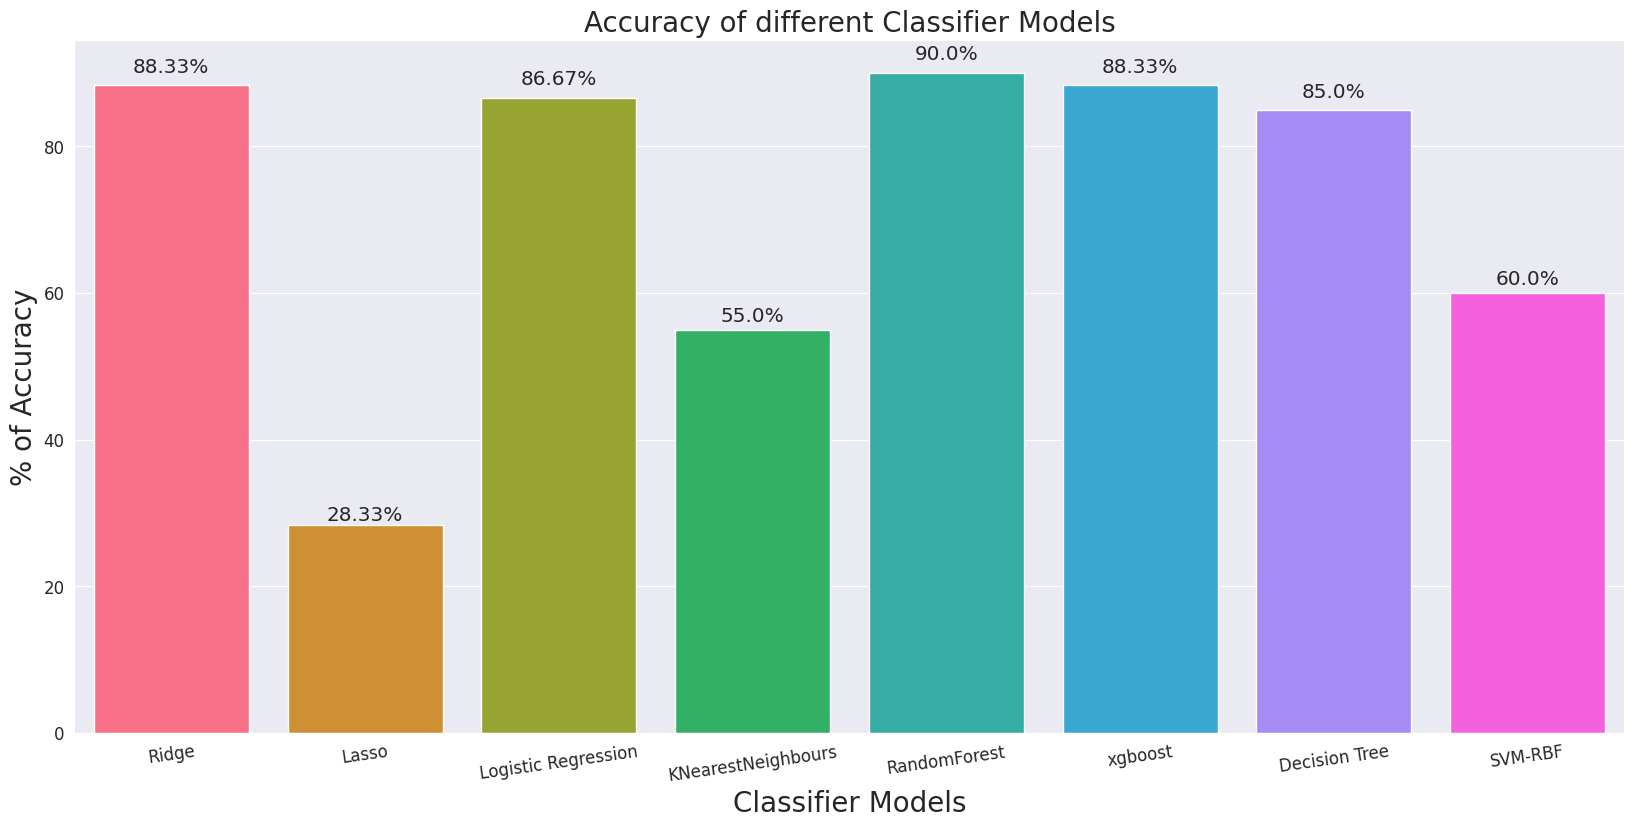

In [ ]:
plt.rcParams['figure.figsize']=20,9
sns.set_style('darkgrid')
ax = sns.barplot(x=list1, y=accuracy_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Accuracy', fontsize = 20)
plt.title('Accuracy of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

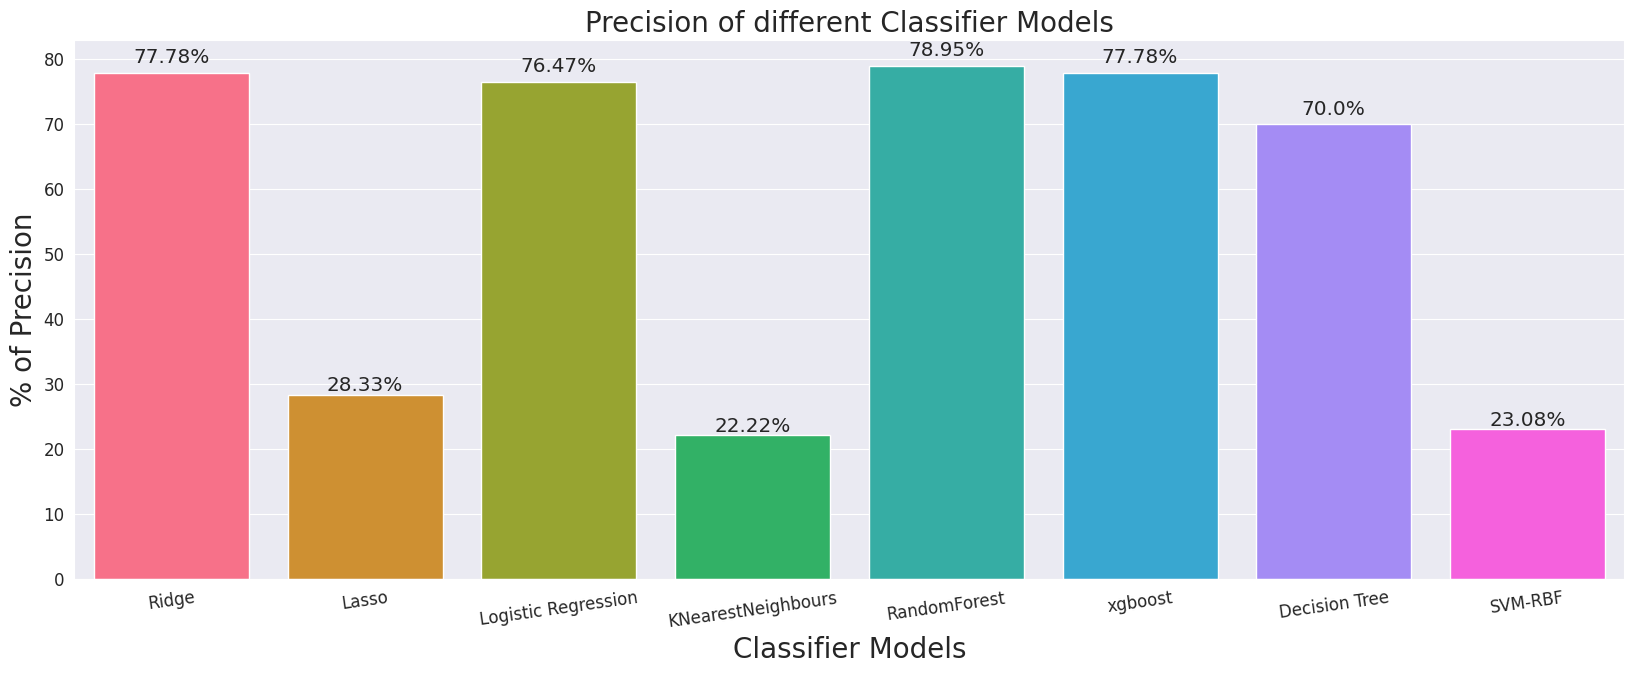

In [ ]:
plt.rcParams['figure.figsize']=20,7
sns.set_style('darkgrid')
ax = sns.barplot(x=list1, y=precision_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Precision', fontsize = 20)
plt.title('Precision of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

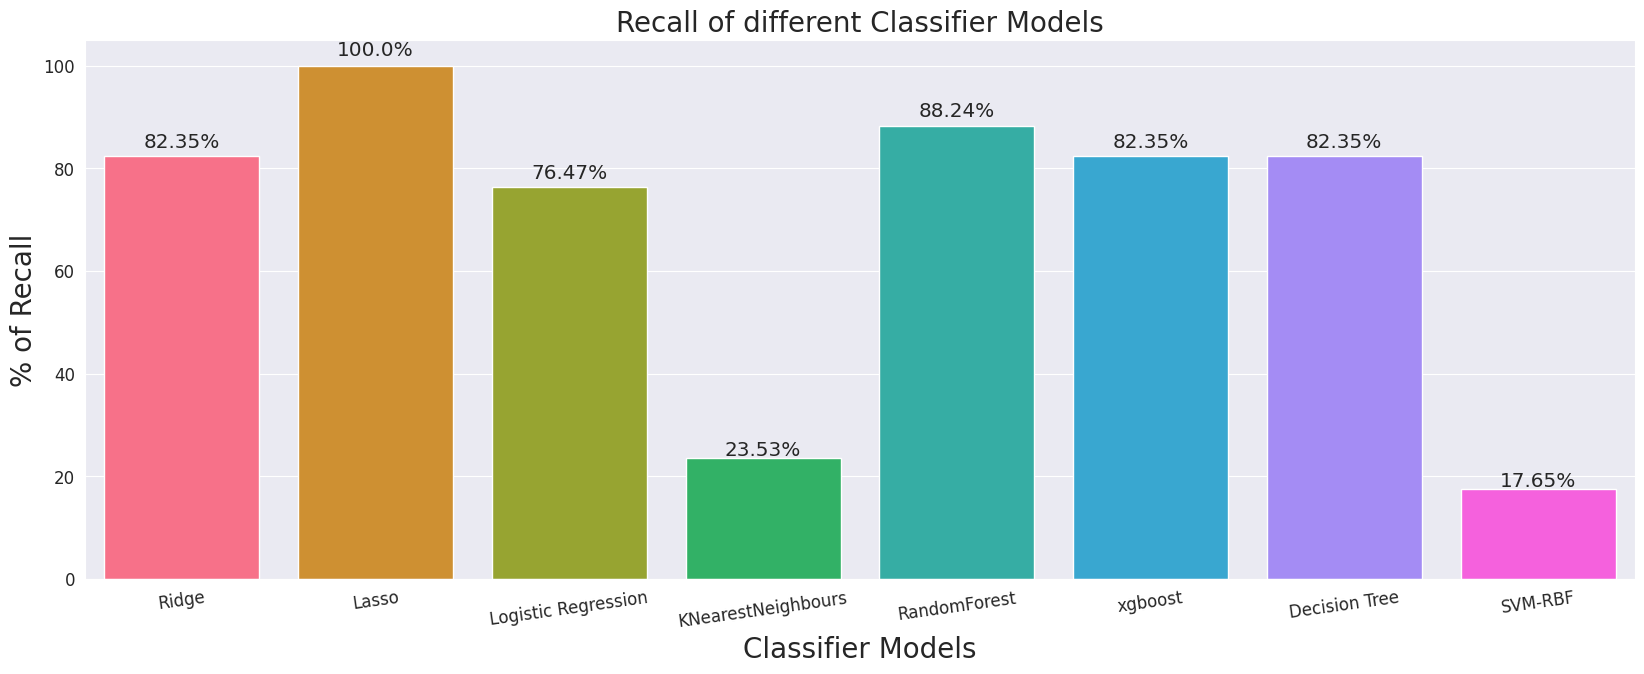

In [ ]:
plt.rcParams['figure.figsize']=20,7
sns.set_style('darkgrid')
ax = sns.barplot(x=list1, y=recall_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Recall', fontsize = 20)
plt.title('Recall of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

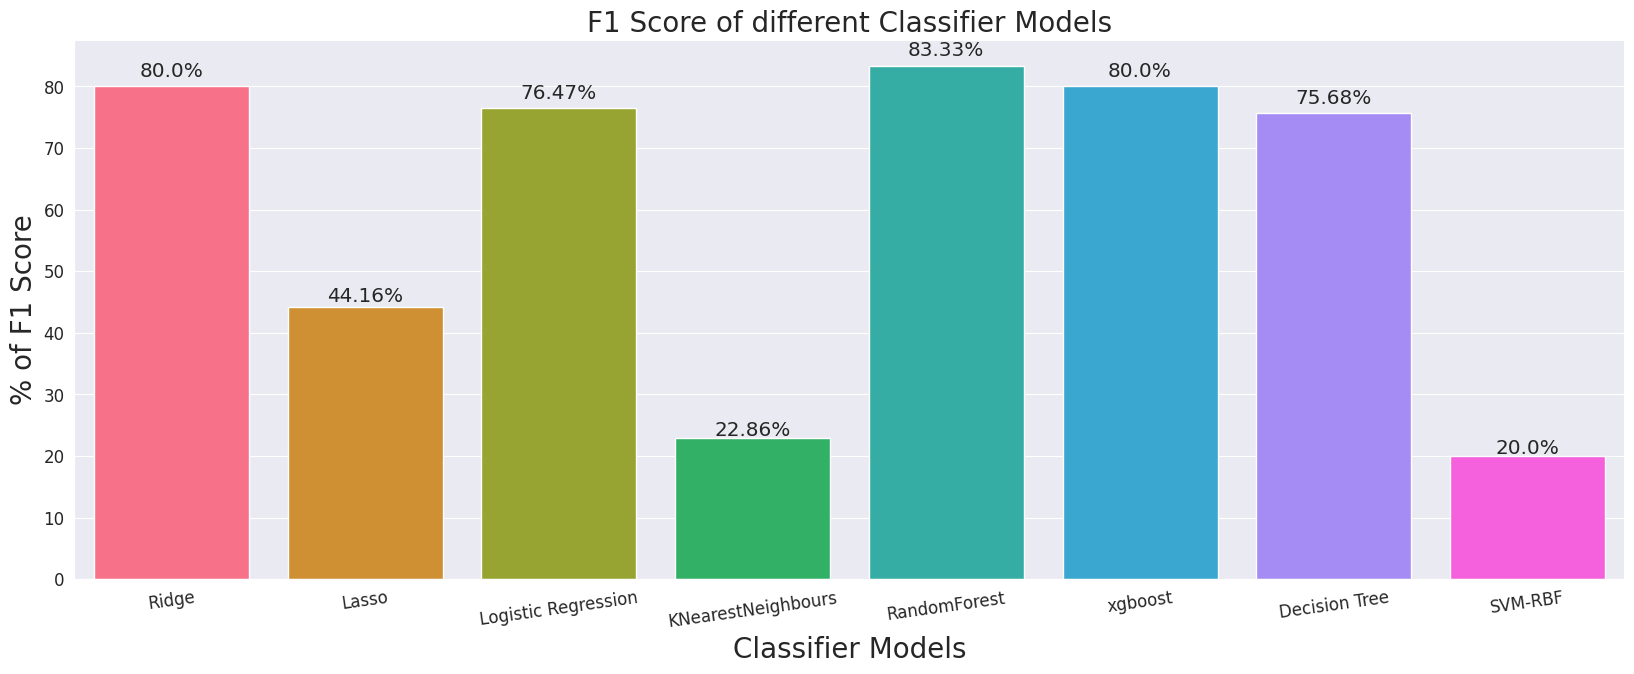

In [ ]:
plt.rcParams['figure.figsize']=20,7
sns.set_style('darkgrid')
ax = sns.barplot(x=list1, y=f1_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of F1 Score', fontsize = 20)
plt.title('F1 Score of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

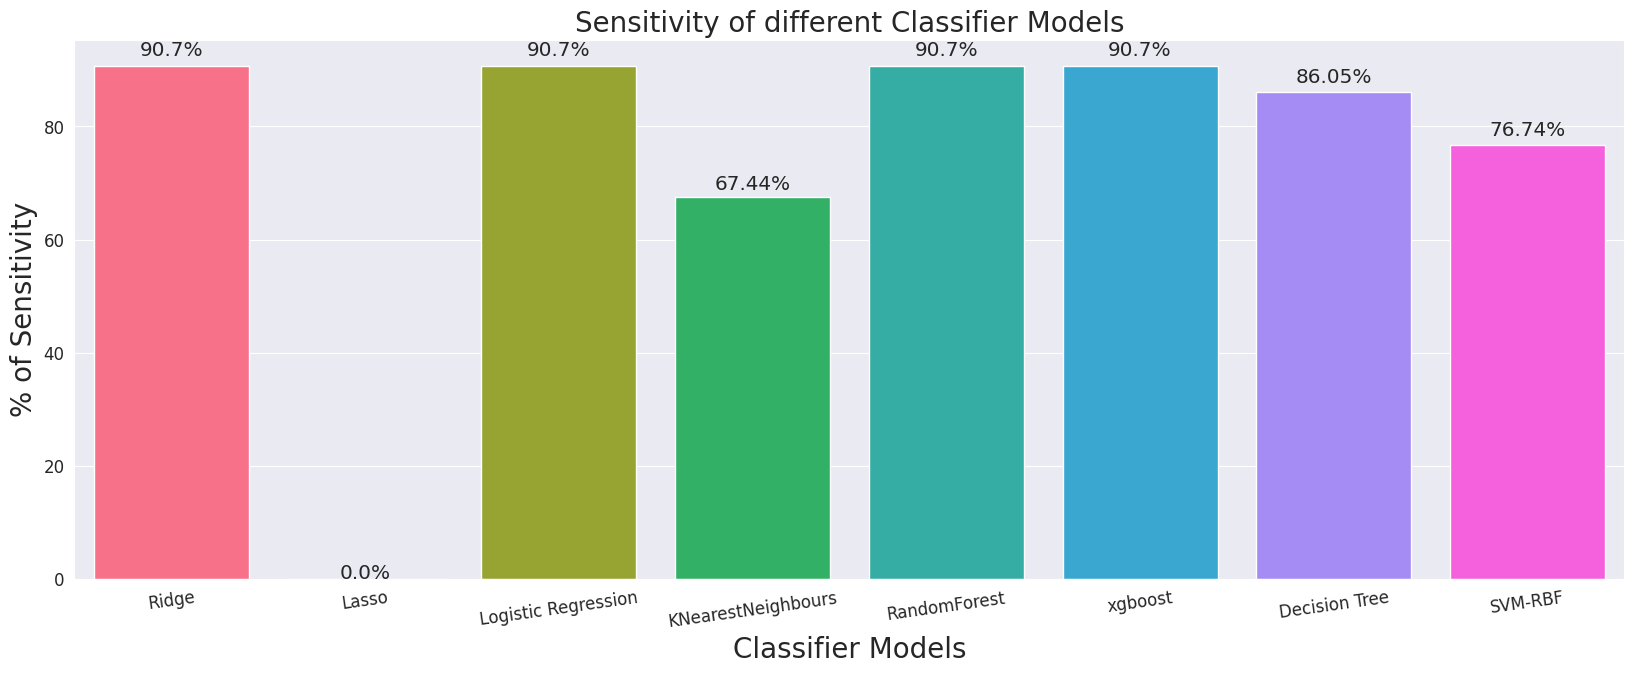

In [ ]:
plt.rcParams['figure.figsize']=20,7
sns.set_style('darkgrid')
ax = sns.barplot(x=list1, y=Sensitivity_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Sensitivity', fontsize = 20)
plt.title('Sensitivity of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

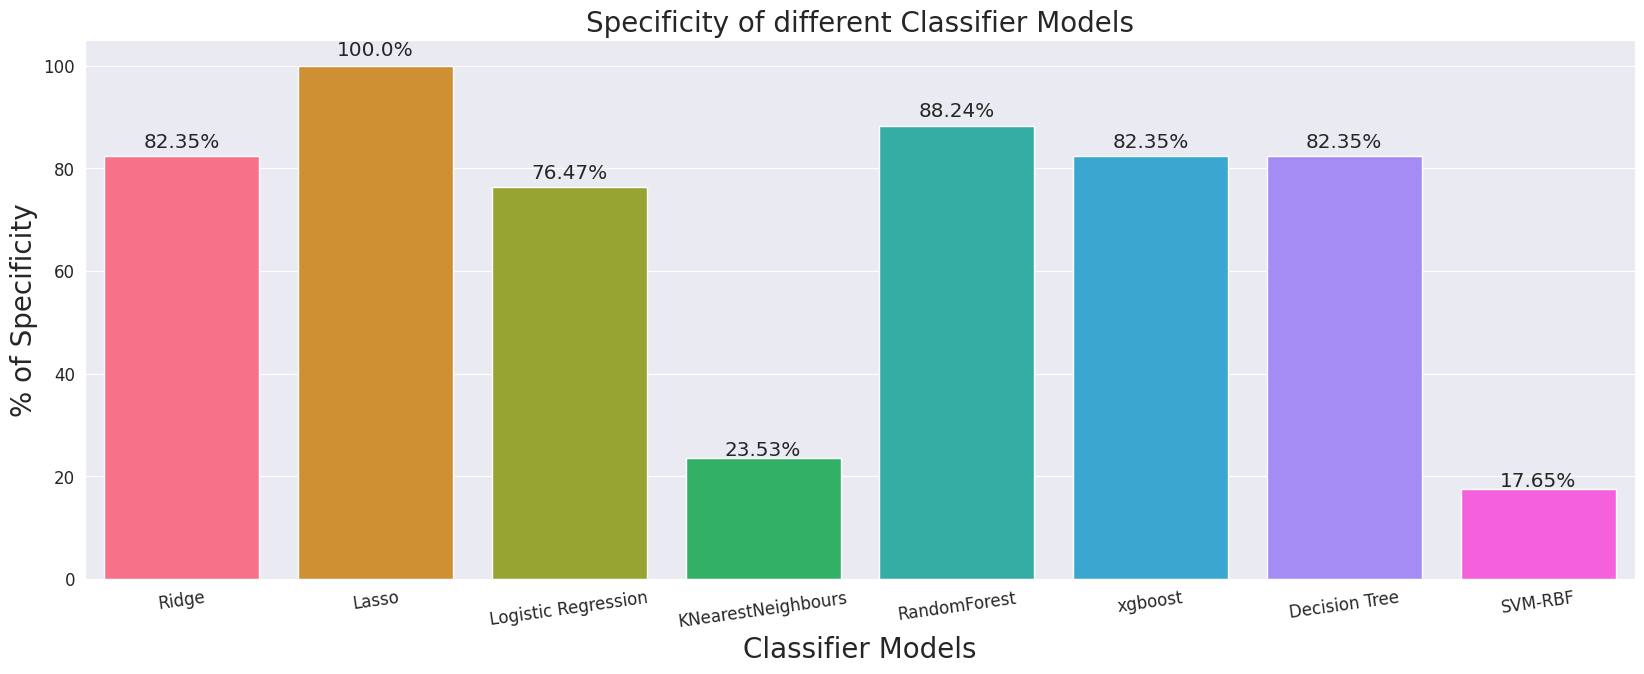

In [ ]:
plt.rcParams['figure.figsize']=20,7
sns.set_style('darkgrid')
ax = sns.barplot(x=list1, y=Specificity_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Specificity', fontsize = 20)
plt.title('Specificity of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

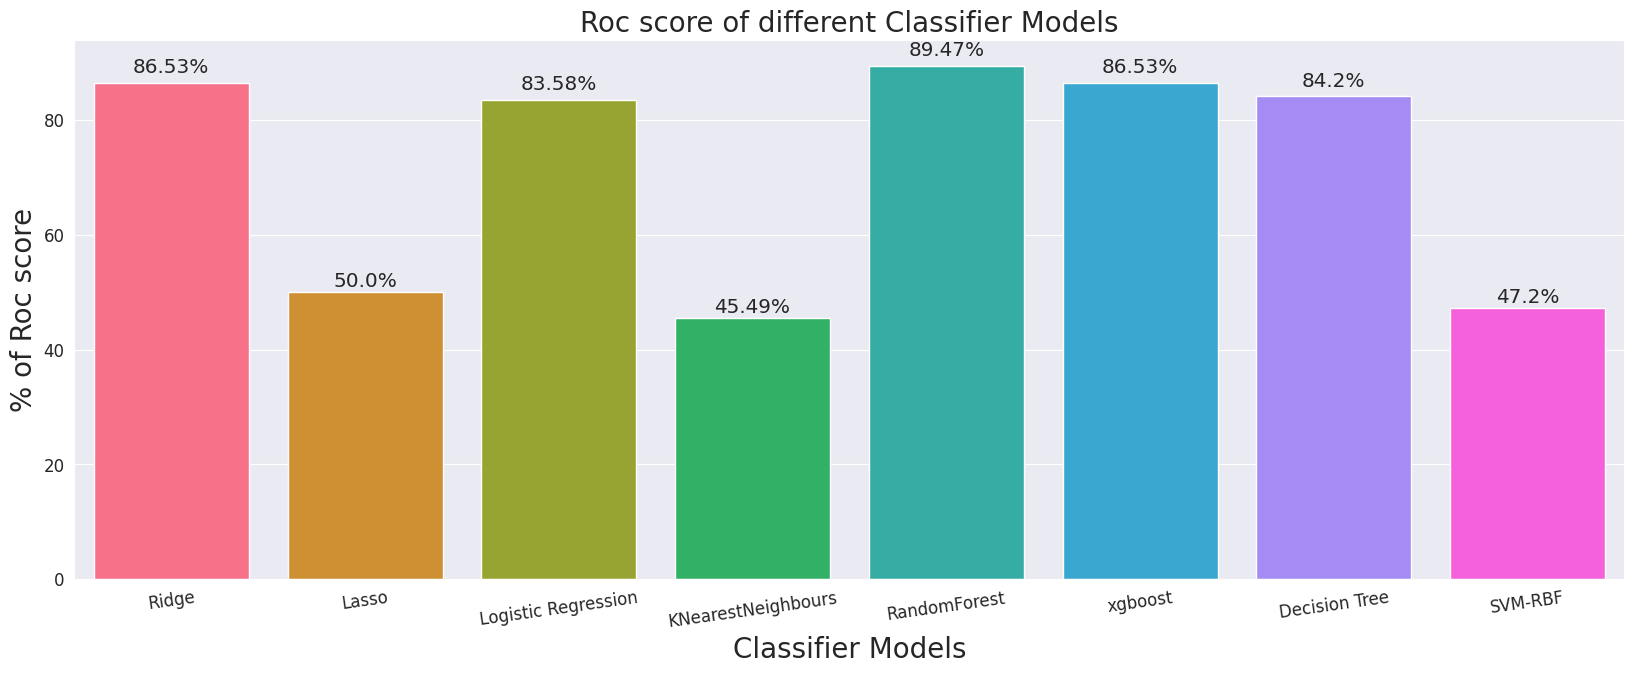

In [ ]:
plt.rcParams['figure.figsize']=20,7
sns.set_style('darkgrid')
ax = sns.barplot(x=list1, y=rocscore_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Roc score', fontsize = 20)
plt.title('Roc score of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

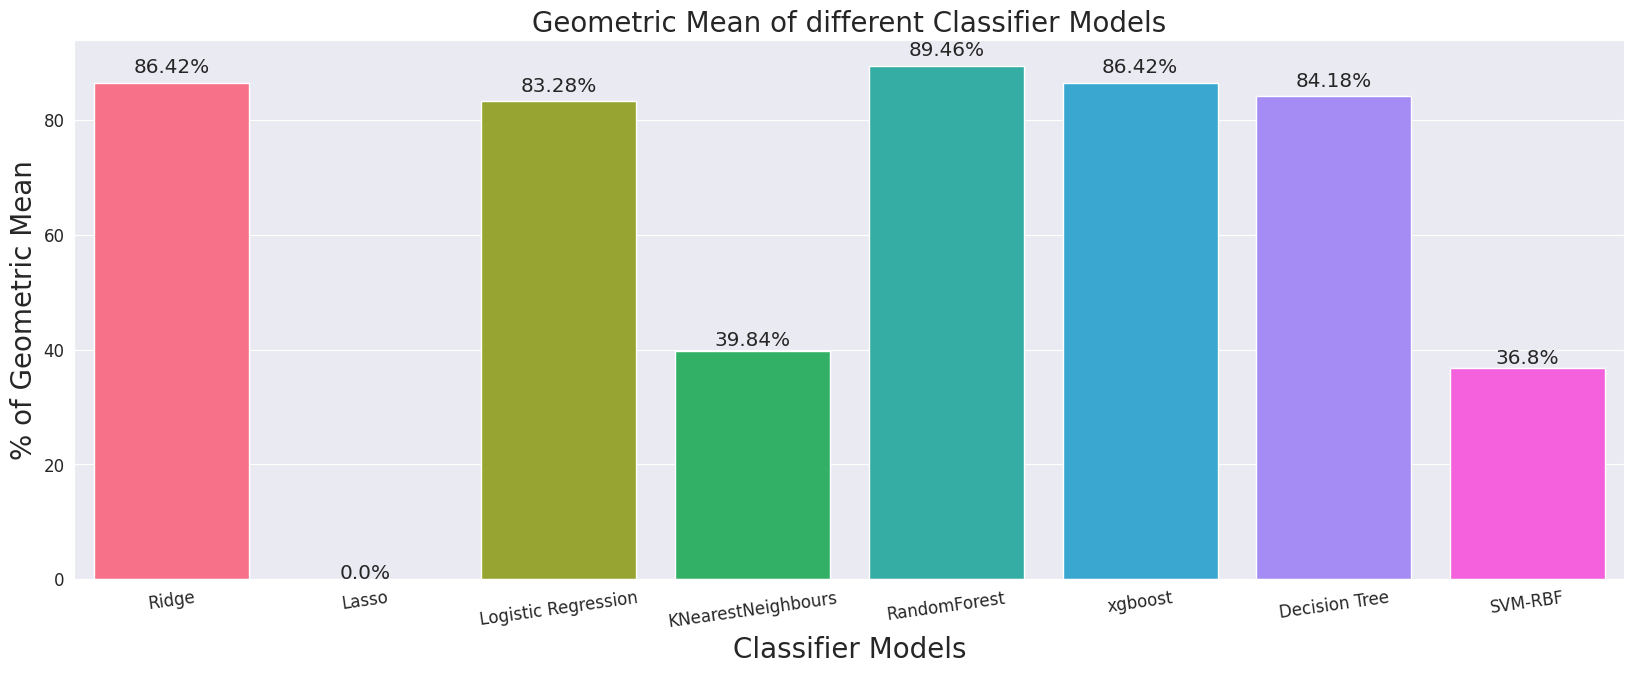

In [ ]:
plt.rcParams['figure.figsize']=20,7
sns.set_style('darkgrid')
ax = sns.barplot(x=list1, y=Gmean_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Geometric Mean', fontsize = 20)
plt.title('Geometric Mean of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()





In [ ]:
import numpy as np
import pandas as pd

# Define the number of rows in the synthetic dataset
num_rows = 10

# Generate synthetic data for each column
age = np.random.randint(25, 85, num_rows)
creatinine_phosphokinase = np.random.randint(20, 8000, num_rows)
ejection_fraction = np.random.randint(20, 80, num_rows)
platelets = np.random.uniform(50000, 400000, num_rows)
serum_creatinine = np.random.uniform(0.5, 9.0, num_rows)
serum_sodium = np.random.randint(120, 150, num_rows)
time = np.random.randint(1, 285, num_rows)
DEATH_EVENT = np.random.randint(0, 2, num_rows)

# Create a dictionary to hold the synthetic data
synthetic_data = {
    'age': age,
    'creatinine_phosphokinase': creatinine_phosphokinase,
    'ejection_fraction': ejection_fraction,
    'platelets': platelets,
    'serum_creatinine': serum_creatinine,
    'serum_sodium': serum_sodium,
    'time': time,
    'DEATH_EVENT': DEATH_EVENT
}

# Convert the dictionary to a Pandas DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Display the synthetic dataset
print(synthetic_df)

# Save the synthetic data to a CSV file
synthetic_df.to_csv('synthetic_data.csv', index=False)


   age  creatinine_phosphokinase  ejection_fraction      platelets  \
0   30                      4778                 21  295689.293008   
1   70                      2776                 37  187985.180278   
2   30                      3206                 68  217067.523061   
3   81                      3318                 57  385661.635784   
4   40                      4282                 48  382218.033506   
5   61                      5911                 76  284922.849850   
6   34                       267                 46  329329.680451   
7   56                      1018                 39  200188.754059   
8   62                      3496                 76  179150.851179   
9   48                       577                 57  306053.058343   

   serum_creatinine  serum_sodium  time  DEATH_EVENT  
0          8.164437           120   270            1  
1          3.563713           146    51            0  
2          6.573723           136    99            1  
3        

In [ ]:
from sklearn.ensemble import StackingClassifier
import pandas as pd

estimators = [
    ('xgb_clf', xgboost.XGBRFClassifier()),
    ('r_clf', RandomForestClassifier()),
    ('log_reg', LogisticRegression())
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(x_train, y_train)

file_path = 'synthetic_data.csv'  # Path to the CSV file containing the dataset
data = pd.read_csv(file_path)

# Select all columns as features for prediction
features = data.iloc[:, :-1]

# Predict the death event for all entries
predictions = stacking_model.predict(features)

# Convert the predicted labels to 'NO' or 'YES'
converted_labels = ['NO' if label == 0 else 'YES' for label in predictions]

# Add the predicted labels to the dataset
data['Predicted Death Event'] = converted_labels

# Save the updated dataset with predicted labels to a new CSV file
data.to_csv('predicted_data.csv', index=False)


[[3 1]
 [4 2]]


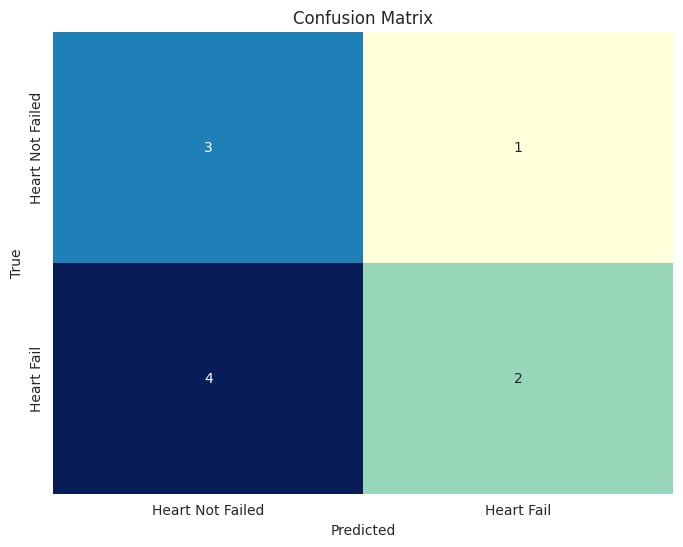

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

file_path = 'synthetic_data.csv'  # Path to the CSV file containing the dataset
data = pd.read_csv(file_path)

y_test = data['DEATH_EVENT'].values

conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0.5, 1.5], ["Heart Not Failed", "Heart Fail"])
plt.yticks([0.5, 1.5], ["Heart Not Failed", "Heart Fail"])
plt.show()


In [ ]:
list_score=[]

In [ ]:
print("The Performance Score:")
acc_stack = accuracy_score(y_test, predictions) # evaluating accuracy
print('Accuracy score of Stacked Model:', acc_stack * 100)
list_score.append(100*acc_stack)

prec=precision_score(y_test,predictions)
print("Precision:",prec)
list_score.append(100*prec)

rec=recall_score(y_test,predictions)
print("Recall:",rec)
list_score.append(100*rec)

f1=f1_score(y_test,predictions)
print("F1 Score:",f1)
list_score.append(100*f1)

total1=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity:', sensitivity )
list_score.append(100*sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity:', specificity)
list_score.append(100*specificity)

roc=roc_auc_score(y_test,predictions)
print("ROC Score:",roc)
list_score.append(100*roc)

gm=geometric_mean_score(y_test,predictions)
print("Geometric Mean:",gm)
list_score.append(100*gm)

The Performance Score:
Accuracy score of Stacked Model: 50.0
Precision: 0.6666666666666666
Recall: 0.3333333333333333
F1 Score: 0.4444444444444444
Sensitivity: 0.7674418604651163
Specificity: 0.17647058823529413
ROC Score: 0.5416666666666666
Geometric Mean: 0.49999999999999994


In [ ]:
list2 = ['Accuracy','Prediction','Recall', 'F1 Score', 'Sensitivity','Specificity ','ROC Score','Geometric Mean']

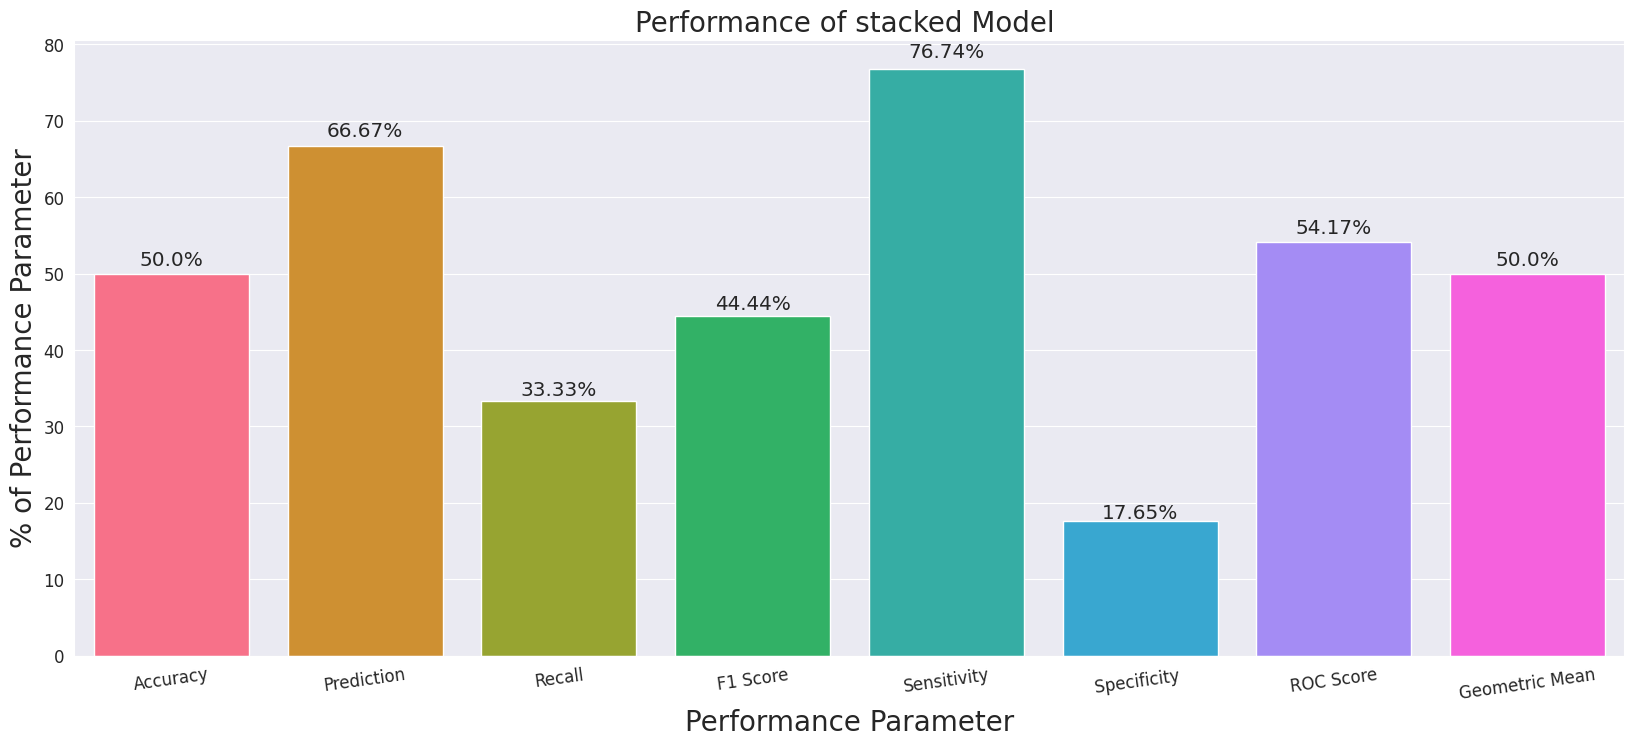

In [ ]:
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
ax = sns.barplot(x=list2, y=list_score, palette = "husl", saturation =2.0)
plt.xlabel('Performance Parameter', fontsize = 20 )
plt.ylabel('% of Performance Parameter', fontsize = 20)
plt.title('Performance of stacked Model ', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()